# Import modules

In [1]:
import csv
import os
import pickle
import pytz
import torch
import timeit
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from copy import deepcopy
from datetime import datetime
from einops import rearrange
from itertools import chain
from time import time
from torch import nn, optim
from torchmetrics.classification import MulticlassAccuracy, MulticlassF1Score, MulticlassConfusionMatrix
from torch.optim import lr_scheduler
from tqdm.notebook import tqdm
from torch.utils.data import TensorDataset, DataLoader
from polyglot.mapping import Embedding, CaseExpander, DigitExpander

# Hyperparameters

In [2]:
class Hyperparams:
     def __init__(
        self,
        fold=2,
        max_seq_len=82,
        input_size=64,
        batch_size=32,
        num_hidden_layer=1,
        hidden_size=128,
        dropout=0,
        bias=True,
        output_size=24,
        shuffle=True,
        lr=0.005,
        batch_first=False,
        bidirectional=True,
        init_wb_with_kaiming_normal=True,
        n_epoch=50,
        patience=50,
        device="cuda" if torch.cuda.is_available() else "cpu"
    ):
        self.fold = fold
        self.input_size = input_size
        self.max_seq_len = max_seq_len
        self.batch_size = batch_size
        self.num_hidden_layer = num_hidden_layer
        self.hidden_size = hidden_size
        self.dropout = dropout
        self.bias = bias
        self.output_size = output_size
        self.shuffle = shuffle
        self.lr = lr
        self.batch_first = batch_first
        self.bidirectional = bidirectional
        self.init_wb_with_kaiming_normal = init_wb_with_kaiming_normal
        self.n_epoch = n_epoch
        self.patience = patience
        self.device = device

hyperparams = Hyperparams()

# Dataset

In [3]:
id_pos_tag = pd.read_csv("../../datasets/raw/Indonesian_Manually_Tagged_Corpus.tsv", sep="\t", header=None, names=["token", "tag"], quoting=csv.QUOTE_NONE, skip_blank_lines=False) 
train = pd.read_csv(f"../../datasets/raw/cv/train/train.0{hyperparams.fold}.tsv", sep="\t", header=None, names=["token", "tag"], quoting=csv.QUOTE_NONE, skip_blank_lines=False)
val = pd.read_csv(f"../../datasets/raw/cv/val/val.0{hyperparams.fold}.tsv", sep="\t", header=None, names=["token", "tag"], quoting=csv.QUOTE_NONE, skip_blank_lines=False)
test = pd.read_csv(f"../../datasets/raw/cv/test/test.0{hyperparams.fold}.tsv", sep="\t", header=None, names=["token", "tag"], quoting=csv.QUOTE_NONE, skip_blank_lines=False)

# Pre-trained Word Embedding

In [4]:
embeddings = Embedding.load("../../word_embeddings/polyglot/idn_embeddings.tar.bz2")
embeddings.apply_expansion(DigitExpander)
embeddings.apply_expansion(CaseExpander)

oov_embeddings = pickle.load(open(f"../../logs/comick/79_contexts/10-11-2022_19-39-04/oov_embedding_dict.pkl", "rb"))
oov_embeddings = {key: np.zeros((64), dtype=np.float32) for key, _ in oov_embeddings.items()}

# Data Preprocessing

## Add OOV Flag

In [5]:
def add_oov_flag(tokens, embeddings):
    oov_flags = []
    
    for token in tqdm(tokens):
        try:
            if token not in embeddings:
                oov_flags.append(True)
            else:
                oov_flags.append(False)
        except:
            oov_flags.append(False)
        
    return pd.DataFrame(oov_flags, columns=["is_oov"])

id_pos_tag_oov_flags = add_oov_flag(id_pos_tag["token"].values, embeddings)
train_oov_flags = add_oov_flag(train["token"].values, embeddings)
val_oov_flags = add_oov_flag(val["token"].values, embeddings)
test_oov_flags = add_oov_flag(test["token"].values, embeddings)

  0%|          | 0/266652 [00:00<?, ?it/s]

  0%|          | 0/192008 [00:00<?, ?it/s]

  0%|          | 0/21405 [00:00<?, ?it/s]

  0%|          | 0/53239 [00:00<?, ?it/s]

## Concate OOV Flag

In [6]:
id_pos_tag_df = pd.concat([id_pos_tag, id_pos_tag_oov_flags], axis=1)
train_df = pd.concat([train, train_oov_flags], axis=1)
val_df = pd.concat([val, val_oov_flags], axis=1)
test_df = pd.concat([test, test_oov_flags], axis=1)

## Lowercase OOV Token

In [7]:
id_pos_tag_df['token'] = np.where(id_pos_tag_df['is_oov'] == True, id_pos_tag_df['token'].str.lower(), id_pos_tag_df['token'])
train_df['token'] = np.where(train_df['is_oov'] == True, train_df['token'].str.lower(), train_df['token'])
val_df['token'] = np.where(val_df['is_oov'] == True, val_df['token'].str.lower(), val_df['token'])
test_df['token'] = np.where(test_df['is_oov'] == True, test_df['token'].str.lower(), test_df['token'])

## Embedding Dict, Index to Token and Token to Index

In [8]:
tokens = list(id_pos_tag_df[["token", "tag", "is_oov"]].itertuples(index=False, name=None))

def embedding_dict(tokens, embeddings, oov_embeddings):
    embedding = {}
    
    for token in tokens:
        if token[0] is not np.nan:
            if token[2] == False or token[0] in embeddings:
                embedding[token[0]] = embeddings[token[0]]
            else:
                embedding[token[0]] = oov_embeddings[token[0].lower()]

    return embedding

embedding_dict = embedding_dict(tokens, embeddings, oov_embeddings)
embedding_dict["<PAD>"] = embeddings["<PAD>"]
word_embeddings = nn.Embedding.from_pretrained(torch.FloatTensor(np.array(list(embedding_dict.values()))), padding_idx=list(embedding_dict.keys()).index("<PAD>"), freeze=True)

idx_to_token = {idx: token for idx, token in enumerate(list(embedding_dict.keys()))}
token_to_idx = {token: idx for idx, token in enumerate(list(embedding_dict.keys()))}

## Token to Sentence

In [9]:
def make_sentence(tokens, max_length_sentence=hyperparams.max_seq_len):
    sentence = []
    sentences = []

    for token in tqdm(tokens):
        if token[0] is not np.nan:
            sentence.append(token)
        else:
            sentences.append(sentence[:max_length_sentence])
            sentence = []

    return sentences

all_sentence = make_sentence(list(id_pos_tag_df[["token", "tag", "is_oov"]].itertuples(index=False, name=None)))
train_sentences = make_sentence(list(train_df[["token", "tag", "is_oov"]].itertuples(index=False, name=None)))
val_sentences = make_sentence(list(test_df[["token", "tag", "is_oov"]].itertuples(index=False, name=None)))
test_sentences = make_sentence(list(val_df[["token", "tag", "is_oov"]].itertuples(index=False, name=None)))

  0%|          | 0/266652 [00:00<?, ?it/s]

  0%|          | 0/192008 [00:00<?, ?it/s]

  0%|          | 0/53239 [00:00<?, ?it/s]

  0%|          | 0/21405 [00:00<?, ?it/s]

## Word Token, Padding, and Word token to Index 

In [10]:
def tokenize_docs(docs, idx_token):
    new_sentence = []
    sentences = []
    
    for sentence in tqdm(docs):
        for token in sentence:
            new_sentence.append(token[idx_token])
        sentences.append(new_sentence)
        new_sentence = []

    return sentences

def padding(docs, max_seq_len=hyperparams.max_seq_len, mode="post", val_pad="<PAD>"):
    docs = deepcopy(docs)
    doc_with_pad = []
    docs_with_pad = []

    for doc in tqdm(docs):
        if mode == "pre":
            for _ in range(max_seq_len - len(doc)):
                doc.insert(0, val_pad)
        elif mode == "post":
            for _ in range(max_seq_len - len(doc)):
                doc.append(val_pad)
        else:
            return f"Mode {mode} is not available, use instead 'pre' or 'post'."
        
        docs_with_pad.append(doc)
        
    return np.array(docs_with_pad)

def sent_to_idx(docs, token_to_idx):
    new_sentence = []
    sentences = []
    
    for sentence in tqdm(docs):
        for token in sentence:
            new_sentence.append(token_to_idx[token])
        sentences.append(new_sentence)
        new_sentence = []

    return np.array(sentences)

def convert_feature_to_idx(docs, idx_token, token_to_idx, max_seq_len):
    sentences = tokenize_docs(docs, idx_token)
    sentences_with_pad = padding(sentences, max_seq_len=max_seq_len, mode="post", val_pad="<PAD>")
    sentences_to_idx = sent_to_idx(sentences_with_pad, token_to_idx)
    
    return sentences_to_idx

train_sentence_idxs = convert_feature_to_idx(train_sentences, 0, token_to_idx, hyperparams.max_seq_len)
val_sentence_idxs = convert_feature_to_idx(val_sentences, 0, token_to_idx, hyperparams.max_seq_len)
test_sentence_idxs = convert_feature_to_idx(test_sentences, 0, token_to_idx, hyperparams.max_seq_len)

  0%|          | 0/7222 [00:00<?, ?it/s]

  0%|          | 0/7222 [00:00<?, ?it/s]

  0%|          | 0/7222 [00:00<?, ?it/s]

  0%|          | 0/2006 [00:00<?, ?it/s]

  0%|          | 0/2006 [00:00<?, ?it/s]

  0%|          | 0/2006 [00:00<?, ?it/s]

  0%|          | 0/802 [00:00<?, ?it/s]

  0%|          | 0/802 [00:00<?, ?it/s]

  0%|          | 0/802 [00:00<?, ?it/s]

## Encode Class

In [11]:
classes = sorted(np.delete(id_pos_tag_df["tag"].unique(), 3))
idx_to_label = {idx: label for idx, label in enumerate(classes + ["<PAD>"])}
label_to_idx = {label: idx for idx, label in enumerate(classes + ["<PAD>"])}

def encode_class(docs, label_to_idx, seq_len=hyperparams.max_seq_len):
    class_idxs = []
    classes = []
    
    for sentence in tqdm(docs):
        for token in sentence:
            class_idxs.append(label_to_idx[token[1]])
            
        for _ in range(seq_len - len(sentence)):
            class_idxs.append(label_to_idx["<PAD>"])
                
        classes.append(class_idxs)
        class_idxs = []

    return np.array(classes)
        
train_class_idxs = encode_class(train_sentences, label_to_idx)
val_class_idxs = encode_class(val_sentences, label_to_idx)
test_class_idxs = encode_class(test_sentences, label_to_idx)

print(f"Training shape   : {train_sentence_idxs.shape, train_class_idxs.shape}")
print(f"validation shape : {val_class_idxs.shape, val_class_idxs.shape}")
print(f"Test shape       : {test_sentence_idxs.shape, test_class_idxs.shape}")

  0%|          | 0/7222 [00:00<?, ?it/s]

  0%|          | 0/2006 [00:00<?, ?it/s]

  0%|          | 0/802 [00:00<?, ?it/s]

Training shape   : ((7222, 82), (7222, 82))
validation shape : ((2006, 82), (2006, 82))
Test shape       : ((802, 82), (802, 82))


## Note

- Number of sentences = 10030
- Train : 72% (7222)
- Val   : 8% (802)
- Test  : 20% (2006)

# Build Model

## Feature and Actual Class

In [12]:
train_feature = torch.LongTensor(train_sentence_idxs)
val_feature = torch.LongTensor(val_sentence_idxs)
test_feature = torch.LongTensor(test_sentence_idxs)

train_class = torch.LongTensor(train_class_idxs)
val_class = torch.LongTensor(val_class_idxs)
test_class = torch.LongTensor(test_class_idxs)

In [13]:
train_feature.shape, val_feature.shape, test_feature.shape

(torch.Size([7222, 82]), torch.Size([2006, 82]), torch.Size([802, 82]))

In [14]:
train_class.shape, val_class.shape, test_class.shape

(torch.Size([7222, 82]), torch.Size([2006, 82]), torch.Size([802, 82]))

## Tensor Dataset

In [15]:
train_dataset = TensorDataset(train_feature, train_class)
val_dataset = TensorDataset(val_feature, val_class)
test_dataset = TensorDataset(test_feature, test_class)

## Dataloader

In [16]:
train_dataloader = DataLoader(train_dataset, batch_size=hyperparams.batch_size, shuffle=hyperparams.shuffle)
val_dataloader = DataLoader(val_dataset, batch_size=hyperparams.batch_size, shuffle=hyperparams.shuffle)
test_dataloader = DataLoader(test_dataset, batch_size=hyperparams.batch_size, shuffle=hyperparams.shuffle)

## Model

In [17]:
class POSTagger(nn.Module):
    def __init__(
        self,
        input_size=hyperparams.input_size,
        hidden_size=hyperparams.hidden_size,
        dropout=hyperparams.dropout,
        bias=hyperparams.bias,
        num_layers=hyperparams.num_hidden_layer,
        output_size=hyperparams.output_size,
        batch_first=hyperparams.batch_first,
        bidirectional=hyperparams.bidirectional,
        init_wb_with_kaiming_normal=hyperparams.init_wb_with_kaiming_normal
    ):
        super(POSTagger, self).__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.dropout = dropout
        self.bias = bias
        self.num_layers = num_layers
        self.output_size = output_size
        self.batch_first = batch_first
        self.bidirectional = bidirectional
                
        self.feature = nn.LSTM(
            input_size = self.input_size,
            hidden_size = self.hidden_size,
            bias = self.bias,
            dropout = self.dropout,
            num_layers = self.num_layers,
            batch_first = self.batch_first,
            bidirectional = self.bidirectional
        )
        
        self.classifier = nn.Sequential(
            nn.Linear(in_features=2 * self.hidden_size if hyperparams.bidirectional else self.hidden_size, out_features=self.output_size, bias=self.bias),
            nn.Softmax(dim=-1)
        )
        
        if init_wb_with_kaiming_normal:
            self.init_wb()

    def init_wb(self):
        for module in self.modules():
            if isinstance(module, (nn.Linear, nn.LSTM)):
                for name, param in module.named_parameters():
                    if "weight" in name:
                        nn.init.kaiming_normal_(param)
                    else:
                        nn.init.kaiming_normal_(param.reshape(1, -1))
        
    def forward(self, feature, hidden=None):
        output, (hidden, memory) = self.feature(feature, None)
        prob = self.classifier(output)

        return prob
    
model = POSTagger().to(hyperparams.device)
model

POSTagger(
  (feature): LSTM(64, 128, bidirectional=True)
  (classifier): Sequential(
    (0): Linear(in_features=256, out_features=24, bias=True)
    (1): Softmax(dim=-1)
  )
)

## Optimizer, Criterion, and Metric

In [18]:
optimizer = optim.Adam(model.parameters(), lr=hyperparams.lr)
criterion = nn.CrossEntropyLoss().to(hyperparams.device)
train_metric = MulticlassF1Score(average="micro", num_classes=24, mdmc_average="global", multiclass=True, ignore_index=label_to_idx["<PAD>"]).to(hyperparams.device)
val_metric = MulticlassF1Score(average="micro", num_classes=24, mdmc_average="global", multiclass=True, ignore_index=label_to_idx["<PAD>"]).to(hyperparams.device)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", verbose=True, factor=0.5)

In [19]:
sum(param.numel() for param in model.parameters() if param.requires_grad)

204824

## Training Step

In [20]:
def training_step(dataloader, model, optimizer, criterion, metric, scheduler=None):
    model.train()
    
    batch_losses = []
    batch_metric_scores = []
    
    for batch, (feature, actual_label) in enumerate(tqdm(dataloader), 1):
        # Forward Propagation
        feature = rearrange(feature, "n s -> s n")
        actual_label = rearrange(actual_label, "n s -> s n")
        embedding = word_embeddings(feature)
        
        prob = model(
            embedding.to(hyperparams.device),
            actual_label.to(hyperparams.device)
        )
        
        prob = prob.reshape(-1, prob.shape[-1])
        actual_label = actual_label.reshape(-1)

        loss = criterion(prob, actual_label.to(hyperparams.device))
        metric_score = metric(prob, actual_label.to(hyperparams.device))
        metric_score = metric.compute()
                
        if scheduler is not None:
            scheduler.step(loss)
        
        batch_losses.append(loss.item())
        batch_metric_scores.append(metric_score)
        
        if len(dataloader) < 10:
            if batch % 1 == 0 or batch == len(dataloader):
                batch_name = "Batch-" + str(batch)
                print(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}")
                with open(f"../../logs/zero/fold_{hyperparams.fold}/{path_name}/training_history.txt", "a") as f:
                    f.write(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}\n")
        else:
            if batch % 15 == 0 or batch == len(dataloader):
                batch_name = "Batch-" + str(batch)
                print(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}")
                with open(f"../../logs/zero/fold_{hyperparams.fold}/{path_name}/training_history.txt", "a") as f:
                    f.write(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}\n")
            
        # Backward Propagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    return batch_losses, batch_metric_scores

## Validation Step

In [21]:
def validation_step(dataloader, model, criterion, metric):
    model.eval()
    
    batch_losses = []
    batch_metric_scores = []
    
    with torch.inference_mode():
        for batch, (feature, actual_label) in enumerate(tqdm(dataloader), 1):
            # Forward Propagation
            feature = rearrange(feature, "n s -> s n")
            actual_label = rearrange(actual_label, "n s -> s n")
            embedding = word_embeddings(feature)

            prob = model(
                embedding.to(hyperparams.device),
                actual_label.to(hyperparams.device)
            )

            prob = prob.reshape(-1, prob.shape[-1])
            actual_label = actual_label.reshape(-1)

            loss = criterion(prob, actual_label.to(hyperparams.device))
            metric_score = metric(prob, actual_label.to(hyperparams.device))
            metric_score = metric.compute()

            batch_losses.append(loss.item())
            batch_metric_scores.append(metric_score)
            
            if len(dataloader) < 10 and (batch % 1 == 0 or batch == len(dataloader)):
                batch_name = "Batch-" + str(batch)
                print(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}")
                with open(f"../../logs/zero/fold_{hyperparams.fold}/{path_name}/training_history.txt", "a") as f:
                    f.write(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}\n")
            else:
                if batch % 15 == 0 or batch == len(dataloader):
                    batch_name = "Batch-" + str(batch)
                    print(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}")
                    with open(f"../../logs/zero/fold_{hyperparams.fold}/{path_name}/training_history.txt", "a") as f:
                        f.write(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}\n")
    
    return batch_losses, batch_metric_scores

## Looping Step

EPOCH-1
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.4663 | MulticlassF1Score=0.1725
Batch-30 : CrossEntropyLoss=2.5225 | MulticlassF1Score=0.2065
Batch-45 : CrossEntropyLoss=2.4511 | MulticlassF1Score=0.2442
Batch-60 : CrossEntropyLoss=2.4493 | MulticlassF1Score=0.2748
Batch-75 : CrossEntropyLoss=2.3957 | MulticlassF1Score=0.3263
Batch-90 : CrossEntropyLoss=2.3579 | MulticlassF1Score=0.3769
Batch-105: CrossEntropyLoss=2.3654 | MulticlassF1Score=0.4115
Batch-120: CrossEntropyLoss=2.3531 | MulticlassF1Score=0.4415
Batch-135: CrossEntropyLoss=2.3639 | MulticlassF1Score=0.4653
Batch-150: CrossEntropyLoss=2.3669 | MulticlassF1Score=0.4835
Batch-165: CrossEntropyLoss=2.3613 | MulticlassF1Score=0.4990
Batch-180: CrossEntropyLoss=2.3447 | MulticlassF1Score=0.5119
Batch-195: CrossEntropyLoss=2.3486 | MulticlassF1Score=0.5240
Batch-210: CrossEntropyLoss=2.3506 | MulticlassF1Score=0.5355
Batch-225: CrossEntropyLoss=2.3513 | MulticlassF1Score=0.5459
Batch-226: CrossEntropyLoss=2.3309 | MulticlassF1Score=0.5464

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3380 | MulticlassF1Score=0.6954
Batch-30 : CrossEntropyLoss=2.3456 | MulticlassF1Score=0.6998
Batch-45 : CrossEntropyLoss=2.3433 | MulticlassF1Score=0.6958
Batch-60 : CrossEntropyLoss=2.3392 | MulticlassF1Score=0.6955
Batch-63 : CrossEntropyLoss=2.3422 | MulticlassF1Score=0.6957

Training   : Mean CrossEntropyLoss = 2.3998 | Mean MulticlassF1Score = 0.3891
Validation : Mean CrossEntropyLoss = 2.3431 | Mean MulticlassF1Score = 0.6970

EPOCH-2
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3422 | MulticlassF1Score=0.6893
Batch-30 : CrossEntropyLoss=2.3370 | MulticlassF1Score=0.6923
Batch-45 : CrossEntropyLoss=2.3351 | MulticlassF1Score=0.6954
Batch-60 : CrossEntropyLoss=2.3205 | MulticlassF1Score=0.6954
Batch-75 : CrossEntropyLoss=2.3415 | MulticlassF1Score=0.6970
Batch-90 : CrossEntropyLoss=2.3432 | MulticlassF1Score=0.6970
Batch-105: CrossEntropyLoss=2.3434 | MulticlassF1Score=0.6984
Batch-120: CrossEntropyLoss=2.3559 | MulticlassF1Score=0.6992
Batch-135: CrossEntropyLoss=2.3434 | MulticlassF1Score=0.6987
Batch-150: CrossEntropyLoss=2.3334 | MulticlassF1Score=0.6986
Batch-165: CrossEntropyLoss=2.3379 | MulticlassF1Score=0.6994
Batch-180: CrossEntropyLoss=2.3371 | MulticlassF1Score=0.6997
Batch-195: CrossEntropyLoss=2.3536 | MulticlassF1Score=0.6997
Batch-210: CrossEntropyLoss=2.3371 | MulticlassF1Score=0.7000
Batch-225: CrossEntropyLoss=2.3255 | MulticlassF1Score=0.7001
Batch-226: CrossEntropyLoss=2.3260 | MulticlassF1Score=0.7003

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3430 | MulticlassF1Score=0.6955
Batch-30 : CrossEntropyLoss=2.3472 | MulticlassF1Score=0.7026
Batch-45 : CrossEntropyLoss=2.3273 | MulticlassF1Score=0.7054
Batch-60 : CrossEntropyLoss=2.3418 | MulticlassF1Score=0.7052
Batch-63 : CrossEntropyLoss=2.3402 | MulticlassF1Score=0.7049

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.3412 | Mean MulticlassF1Score = 0.6969
Validation : Mean CrossEntropyLoss = 2.3392 | Mean MulticlassF1Score = 0.6999

EPOCH-3
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3302 | MulticlassF1Score=0.7130
Batch-30 : CrossEntropyLoss=2.3297 | MulticlassF1Score=0.7117
Batch-45 : CrossEntropyLoss=2.3208 | MulticlassF1Score=0.7259
Batch-60 : CrossEntropyLoss=2.3173 | MulticlassF1Score=0.7365
Batch-75 : CrossEntropyLoss=2.3197 | MulticlassF1Score=0.7430
Batch-90 : CrossEntropyLoss=2.3096 | MulticlassF1Score=0.7512
Batch-105: CrossEntropyLoss=2.3293 | MulticlassF1Score=0.7555
Batch-120: CrossEntropyLoss=2.3090 | MulticlassF1Score=0.7587
Batch-135: CrossEntropyLoss=2.3106 | MulticlassF1Score=0.7628
Batch-150: CrossEntropyLoss=2.3145 | MulticlassF1Score=0.7658
Batch-165: CrossEntropyLoss=2.3091 | MulticlassF1Score=0.7681
Batch-180: CrossEntropyLoss=2.3188 | MulticlassF1Score=0.7697
Batch-195: CrossEntropyLoss=2.3160 | MulticlassF1Score=0.7716
Batch-210: CrossEntropyLoss=2.3154 | MulticlassF1Score=0.7745
Batch-225: CrossEntropyLoss=2.3075 | MulticlassF1Score=0.7763
Batch-226: CrossEntropyLoss=2.3195 | MulticlassF1Score=0.7763

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3130 | MulticlassF1Score=0.8034
Batch-30 : CrossEntropyLoss=2.3185 | MulticlassF1Score=0.8043
Batch-45 : CrossEntropyLoss=2.3106 | MulticlassF1Score=0.8086
Batch-60 : CrossEntropyLoss=2.3104 | MulticlassF1Score=0.8077
Batch-63 : CrossEntropyLoss=2.3010 | MulticlassF1Score=0.8073

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.3176 | Mean MulticlassF1Score = 0.7497
Validation : Mean CrossEntropyLoss = 2.3078 | Mean MulticlassF1Score = 0.8057

EPOCH-4
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3065 | MulticlassF1Score=0.8064
Batch-30 : CrossEntropyLoss=2.3055 | MulticlassF1Score=0.8073
Batch-45 : CrossEntropyLoss=2.3130 | MulticlassF1Score=0.8091
Batch-60 : CrossEntropyLoss=2.3005 | MulticlassF1Score=0.8098
Batch-75 : CrossEntropyLoss=2.3047 | MulticlassF1Score=0.8116
Batch-90 : CrossEntropyLoss=2.2968 | MulticlassF1Score=0.8120
Batch-105: CrossEntropyLoss=2.2979 | MulticlassF1Score=0.8128
Batch-120: CrossEntropyLoss=2.3169 | MulticlassF1Score=0.8127
Batch-135: CrossEntropyLoss=2.3084 | MulticlassF1Score=0.8131
Batch-150: CrossEntropyLoss=2.3120 | MulticlassF1Score=0.8140
Batch-165: CrossEntropyLoss=2.3233 | MulticlassF1Score=0.8141
Batch-180: CrossEntropyLoss=2.3008 | MulticlassF1Score=0.8133
Batch-195: CrossEntropyLoss=2.3097 | MulticlassF1Score=0.8137
Batch-210: CrossEntropyLoss=2.3033 | MulticlassF1Score=0.8135
Batch-225: CrossEntropyLoss=2.3068 | MulticlassF1Score=0.8139
Batch-226: CrossEntropyLoss=2.2945 | MulticlassF1Score=0.8138

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3075 | MulticlassF1Score=0.8180
Batch-30 : CrossEntropyLoss=2.3007 | MulticlassF1Score=0.8174
Batch-45 : CrossEntropyLoss=2.3113 | MulticlassF1Score=0.8162
Batch-60 : CrossEntropyLoss=2.2961 | MulticlassF1Score=0.8175
Batch-63 : CrossEntropyLoss=2.3114 | MulticlassF1Score=0.8169

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.3058 | Mean MulticlassF1Score = 0.8117
Validation : Mean CrossEntropyLoss = 2.3046 | Mean MulticlassF1Score = 0.8164

EPOCH-5
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3102 | MulticlassF1Score=0.8187
Batch-30 : CrossEntropyLoss=2.3008 | MulticlassF1Score=0.8165
Batch-45 : CrossEntropyLoss=2.3031 | MulticlassF1Score=0.8192
Batch-60 : CrossEntropyLoss=2.2920 | MulticlassF1Score=0.8198
Batch-75 : CrossEntropyLoss=2.3148 | MulticlassF1Score=0.8206
Batch-90 : CrossEntropyLoss=2.2940 | MulticlassF1Score=0.8205
Batch-105: CrossEntropyLoss=2.3090 | MulticlassF1Score=0.8214
Batch-120: CrossEntropyLoss=2.3091 | MulticlassF1Score=0.8209
Batch-135: CrossEntropyLoss=2.3057 | MulticlassF1Score=0.8207
Batch-150: CrossEntropyLoss=2.3126 | MulticlassF1Score=0.8195
Batch-165: CrossEntropyLoss=2.3246 | MulticlassF1Score=0.8192
Batch-180: CrossEntropyLoss=2.2948 | MulticlassF1Score=0.8192
Batch-195: CrossEntropyLoss=2.2915 | MulticlassF1Score=0.8189
Batch-210: CrossEntropyLoss=2.3015 | MulticlassF1Score=0.8191
Batch-225: CrossEntropyLoss=2.2982 | MulticlassF1Score=0.8189
Batch-226: CrossEntropyLoss=2.3198 | MulticlassF1Score=0.8188

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2982 | MulticlassF1Score=0.8217
Batch-30 : CrossEntropyLoss=2.2971 | MulticlassF1Score=0.8208
Batch-45 : CrossEntropyLoss=2.3057 | MulticlassF1Score=0.8211
Batch-60 : CrossEntropyLoss=2.3036 | MulticlassF1Score=0.8197
Batch-63 : CrossEntropyLoss=2.3187 | MulticlassF1Score=0.8190

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.3040 | Mean MulticlassF1Score = 0.8196
Validation : Mean CrossEntropyLoss = 2.3039 | Mean MulticlassF1Score = 0.8205

EPOCH-6
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3051 | MulticlassF1Score=0.8171
Batch-30 : CrossEntropyLoss=2.2956 | MulticlassF1Score=0.8210
Batch-45 : CrossEntropyLoss=2.3007 | MulticlassF1Score=0.8209
Batch-60 : CrossEntropyLoss=2.2991 | MulticlassF1Score=0.8230
Batch-75 : CrossEntropyLoss=2.3015 | MulticlassF1Score=0.8227
Batch-90 : CrossEntropyLoss=2.3029 | MulticlassF1Score=0.8222
Batch-105: CrossEntropyLoss=2.3024 | MulticlassF1Score=0.8218
Batch-120: CrossEntropyLoss=2.2932 | MulticlassF1Score=0.8217
Batch-135: CrossEntropyLoss=2.3014 | MulticlassF1Score=0.8216
Batch-150: CrossEntropyLoss=2.2989 | MulticlassF1Score=0.8222
Batch-165: CrossEntropyLoss=2.3039 | MulticlassF1Score=0.8222
Batch-180: CrossEntropyLoss=2.3028 | MulticlassF1Score=0.8219
Batch-195: CrossEntropyLoss=2.3036 | MulticlassF1Score=0.8225
Batch-210: CrossEntropyLoss=2.3011 | MulticlassF1Score=0.8219
Batch-225: CrossEntropyLoss=2.2987 | MulticlassF1Score=0.8217
Batch-226: CrossEntropyLoss=2.2935 | MulticlassF1Score=0.8218

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3044 | MulticlassF1Score=0.8132
Batch-30 : CrossEntropyLoss=2.2938 | MulticlassF1Score=0.8180
Batch-45 : CrossEntropyLoss=2.2963 | MulticlassF1Score=0.8190
Batch-60 : CrossEntropyLoss=2.3088 | MulticlassF1Score=0.8190
Batch-63 : CrossEntropyLoss=2.2893 | MulticlassF1Score=0.8189

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.3030 | Mean MulticlassF1Score = 0.8213
Validation : Mean CrossEntropyLoss = 2.3034 | Mean MulticlassF1Score = 0.8163

EPOCH-7
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3081 | MulticlassF1Score=0.8151
Batch-30 : CrossEntropyLoss=2.3017 | MulticlassF1Score=0.8190
Batch-45 : CrossEntropyLoss=2.2982 | MulticlassF1Score=0.8219
Batch-60 : CrossEntropyLoss=2.3045 | MulticlassF1Score=0.8218
Batch-75 : CrossEntropyLoss=2.3035 | MulticlassF1Score=0.8234
Batch-90 : CrossEntropyLoss=2.2977 | MulticlassF1Score=0.8251
Batch-105: CrossEntropyLoss=2.2942 | MulticlassF1Score=0.8253
Batch-120: CrossEntropyLoss=2.3001 | MulticlassF1Score=0.8257
Batch-135: CrossEntropyLoss=2.2952 | MulticlassF1Score=0.8270
Batch-150: CrossEntropyLoss=2.3049 | MulticlassF1Score=0.8276
Batch-165: CrossEntropyLoss=2.2970 | MulticlassF1Score=0.8275
Batch-180: CrossEntropyLoss=2.3029 | MulticlassF1Score=0.8276
Batch-195: CrossEntropyLoss=2.3004 | MulticlassF1Score=0.8281
Batch-210: CrossEntropyLoss=2.3065 | MulticlassF1Score=0.8286
Batch-225: CrossEntropyLoss=2.3008 | MulticlassF1Score=0.8292
Batch-226: CrossEntropyLoss=2.2970 | MulticlassF1Score=0.8293

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2934 | MulticlassF1Score=0.8303
Batch-30 : CrossEntropyLoss=2.3021 | MulticlassF1Score=0.8307
Batch-45 : CrossEntropyLoss=2.2949 | MulticlassF1Score=0.8283
Batch-60 : CrossEntropyLoss=2.3080 | MulticlassF1Score=0.8289
Batch-63 : CrossEntropyLoss=2.3083 | MulticlassF1Score=0.8287

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.3006 | Mean MulticlassF1Score = 0.8245
Validation : Mean CrossEntropyLoss = 2.3006 | Mean MulticlassF1Score = 0.8296

EPOCH-8
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3038 | MulticlassF1Score=0.8318
Batch-30 : CrossEntropyLoss=2.2948 | MulticlassF1Score=0.8338
Batch-45 : CrossEntropyLoss=2.2910 | MulticlassF1Score=0.8352
Batch-60 : CrossEntropyLoss=2.2877 | MulticlassF1Score=0.8413
Batch-75 : CrossEntropyLoss=2.2789 | MulticlassF1Score=0.8488
Batch-90 : CrossEntropyLoss=2.2868 | MulticlassF1Score=0.8548
Batch-105: CrossEntropyLoss=2.2877 | MulticlassF1Score=0.8593
Batch-120: CrossEntropyLoss=2.2872 | MulticlassF1Score=0.8623
Batch-135: CrossEntropyLoss=2.2804 | MulticlassF1Score=0.8649
Batch-150: CrossEntropyLoss=2.2838 | MulticlassF1Score=0.8676
Batch-165: CrossEntropyLoss=2.2832 | MulticlassF1Score=0.8694
Batch-180: CrossEntropyLoss=2.2817 | MulticlassF1Score=0.8708
Batch-195: CrossEntropyLoss=2.2711 | MulticlassF1Score=0.8724
Batch-210: CrossEntropyLoss=2.2957 | MulticlassF1Score=0.8735
Batch-225: CrossEntropyLoss=2.2773 | MulticlassF1Score=0.8744
Batch-226: CrossEntropyLoss=2.2799 | MulticlassF1Score=0.8745

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2846 | MulticlassF1Score=0.8849
Batch-30 : CrossEntropyLoss=2.2860 | MulticlassF1Score=0.8851
Batch-45 : CrossEntropyLoss=2.2868 | MulticlassF1Score=0.8856
Batch-60 : CrossEntropyLoss=2.2864 | MulticlassF1Score=0.8855
Batch-63 : CrossEntropyLoss=2.2905 | MulticlassF1Score=0.8854

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2871 | Mean MulticlassF1Score = 0.8558
Validation : Mean CrossEntropyLoss = 2.2837 | Mean MulticlassF1Score = 0.8857

EPOCH-9
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2774 | MulticlassF1Score=0.8973
Batch-30 : CrossEntropyLoss=2.2889 | MulticlassF1Score=0.8976
Batch-45 : CrossEntropyLoss=2.2737 | MulticlassF1Score=0.8985
Batch-60 : CrossEntropyLoss=2.2737 | MulticlassF1Score=0.8976
Batch-75 : CrossEntropyLoss=2.2812 | MulticlassF1Score=0.8969
Batch-90 : CrossEntropyLoss=2.2844 | MulticlassF1Score=0.8960
Batch-105: CrossEntropyLoss=2.2861 | MulticlassF1Score=0.8960
Batch-120: CrossEntropyLoss=2.2828 | MulticlassF1Score=0.8955
Batch-135: CrossEntropyLoss=2.2840 | MulticlassF1Score=0.8946
Batch-150: CrossEntropyLoss=2.2817 | MulticlassF1Score=0.8946
Batch-165: CrossEntropyLoss=2.2817 | MulticlassF1Score=0.8948
Batch-180: CrossEntropyLoss=2.2805 | MulticlassF1Score=0.8945
Batch-195: CrossEntropyLoss=2.2787 | MulticlassF1Score=0.8942
Batch-210: CrossEntropyLoss=2.2764 | MulticlassF1Score=0.8940
Batch-225: CrossEntropyLoss=2.2762 | MulticlassF1Score=0.8939
Batch-226: CrossEntropyLoss=2.2853 | MulticlassF1Score=0.8938

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2795 | MulticlassF1Score=0.8905
Batch-30 : CrossEntropyLoss=2.2767 | MulticlassF1Score=0.8866
Batch-45 : CrossEntropyLoss=2.2733 | MulticlassF1Score=0.8886
Batch-60 : CrossEntropyLoss=2.2849 | MulticlassF1Score=0.8884
Batch-63 : CrossEntropyLoss=2.2841 | MulticlassF1Score=0.8884

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2810 | Mean MulticlassF1Score = 0.8960
Validation : Mean CrossEntropyLoss = 2.2824 | Mean MulticlassF1Score = 0.8888

EPOCH-10
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2722 | MulticlassF1Score=0.9021
Batch-30 : CrossEntropyLoss=2.2799 | MulticlassF1Score=0.8983
Batch-45 : CrossEntropyLoss=2.2785 | MulticlassF1Score=0.8976
Batch-60 : CrossEntropyLoss=2.2786 | MulticlassF1Score=0.8994
Batch-75 : CrossEntropyLoss=2.2740 | MulticlassF1Score=0.9015
Batch-90 : CrossEntropyLoss=2.2775 | MulticlassF1Score=0.9035
Batch-105: CrossEntropyLoss=2.2679 | MulticlassF1Score=0.9043
Batch-120: CrossEntropyLoss=2.2741 | MulticlassF1Score=0.9056
Batch-135: CrossEntropyLoss=2.2770 | MulticlassF1Score=0.9064
Batch-150: CrossEntropyLoss=2.2730 | MulticlassF1Score=0.9066
Batch-165: CrossEntropyLoss=2.2733 | MulticlassF1Score=0.9074
Batch-180: CrossEntropyLoss=2.2762 | MulticlassF1Score=0.9076
Batch-195: CrossEntropyLoss=2.2741 | MulticlassF1Score=0.9082
Batch-210: CrossEntropyLoss=2.2722 | MulticlassF1Score=0.9086
Batch-225: CrossEntropyLoss=2.2861 | MulticlassF1Score=0.9086
Batch-226: CrossEntropyLoss=2.2839 | MulticlassF1Score=0.9085

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2800 | MulticlassF1Score=0.9075
Batch-30 : CrossEntropyLoss=2.2772 | MulticlassF1Score=0.9090
Batch-45 : CrossEntropyLoss=2.2826 | MulticlassF1Score=0.9068
Batch-60 : CrossEntropyLoss=2.2760 | MulticlassF1Score=0.9060
Batch-63 : CrossEntropyLoss=2.2737 | MulticlassF1Score=0.9053

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2765 | Mean MulticlassF1Score = 0.9039
Validation : Mean CrossEntropyLoss = 2.2773 | Mean MulticlassF1Score = 0.9092

EPOCH-11
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2727 | MulticlassF1Score=0.9165
Batch-30 : CrossEntropyLoss=2.2726 | MulticlassF1Score=0.9155
Batch-45 : CrossEntropyLoss=2.2787 | MulticlassF1Score=0.9158
Batch-60 : CrossEntropyLoss=2.2732 | MulticlassF1Score=0.9159
Batch-75 : CrossEntropyLoss=2.2721 | MulticlassF1Score=0.9154
Batch-90 : CrossEntropyLoss=2.2680 | MulticlassF1Score=0.9163
Batch-105: CrossEntropyLoss=2.2749 | MulticlassF1Score=0.9161
Batch-120: CrossEntropyLoss=2.2749 | MulticlassF1Score=0.9163
Batch-135: CrossEntropyLoss=2.2760 | MulticlassF1Score=0.9163
Batch-150: CrossEntropyLoss=2.2668 | MulticlassF1Score=0.9164
Batch-165: CrossEntropyLoss=2.2764 | MulticlassF1Score=0.9165
Batch-180: CrossEntropyLoss=2.2777 | MulticlassF1Score=0.9167
Batch-195: CrossEntropyLoss=2.2768 | MulticlassF1Score=0.9165
Batch-210: CrossEntropyLoss=2.2720 | MulticlassF1Score=0.9164
Batch-225: CrossEntropyLoss=2.2792 | MulticlassF1Score=0.9161
Batch-226: CrossEntropyLoss=2.2698 | MulticlassF1Score=0.9161

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2703 | MulticlassF1Score=0.9073
Batch-30 : CrossEntropyLoss=2.2949 | MulticlassF1Score=0.9069
Batch-45 : CrossEntropyLoss=2.2842 | MulticlassF1Score=0.9058
Batch-60 : CrossEntropyLoss=2.2776 | MulticlassF1Score=0.9067
Batch-63 : CrossEntropyLoss=2.2743 | MulticlassF1Score=0.9065

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2740 | Mean MulticlassF1Score = 0.9162
Validation : Mean CrossEntropyLoss = 2.2769 | Mean MulticlassF1Score = 0.9067

EPOCH-12
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2695 | MulticlassF1Score=0.9137
Batch-30 : CrossEntropyLoss=2.2726 | MulticlassF1Score=0.9176
Batch-45 : CrossEntropyLoss=2.2709 | MulticlassF1Score=0.9185
Batch-60 : CrossEntropyLoss=2.2701 | MulticlassF1Score=0.9198
Batch-75 : CrossEntropyLoss=2.2690 | MulticlassF1Score=0.9198
Batch-90 : CrossEntropyLoss=2.2728 | MulticlassF1Score=0.9194
Batch-105: CrossEntropyLoss=2.2759 | MulticlassF1Score=0.9190
Batch-120: CrossEntropyLoss=2.2738 | MulticlassF1Score=0.9187
Batch-135: CrossEntropyLoss=2.2669 | MulticlassF1Score=0.9187
Batch-150: CrossEntropyLoss=2.2711 | MulticlassF1Score=0.9190
Batch-165: CrossEntropyLoss=2.2673 | MulticlassF1Score=0.9190
Batch-180: CrossEntropyLoss=2.2779 | MulticlassF1Score=0.9185
Batch-195: CrossEntropyLoss=2.2764 | MulticlassF1Score=0.9187
Batch-210: CrossEntropyLoss=2.2824 | MulticlassF1Score=0.9186
Batch-225: CrossEntropyLoss=2.2743 | MulticlassF1Score=0.9184
Batch-226: CrossEntropyLoss=2.2754 | MulticlassF1Score=0.9184

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2830 | MulticlassF1Score=0.9042
Batch-30 : CrossEntropyLoss=2.2710 | MulticlassF1Score=0.9041
Batch-45 : CrossEntropyLoss=2.2724 | MulticlassF1Score=0.9064
Batch-60 : CrossEntropyLoss=2.2762 | MulticlassF1Score=0.9066
Batch-63 : CrossEntropyLoss=2.2809 | MulticlassF1Score=0.9065

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2732 | Mean MulticlassF1Score = 0.9180
Validation : Mean CrossEntropyLoss = 2.2767 | Mean MulticlassF1Score = 0.9065

EPOCH-13
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2718 | MulticlassF1Score=0.9205
Batch-30 : CrossEntropyLoss=2.2740 | MulticlassF1Score=0.9199
Batch-45 : CrossEntropyLoss=2.2738 | MulticlassF1Score=0.9208
Batch-60 : CrossEntropyLoss=2.2716 | MulticlassF1Score=0.9186
Batch-75 : CrossEntropyLoss=2.2735 | MulticlassF1Score=0.9194
Batch-90 : CrossEntropyLoss=2.2706 | MulticlassF1Score=0.9192
Batch-105: CrossEntropyLoss=2.2682 | MulticlassF1Score=0.9199
Batch-120: CrossEntropyLoss=2.2723 | MulticlassF1Score=0.9200
Batch-135: CrossEntropyLoss=2.2713 | MulticlassF1Score=0.9201
Batch-150: CrossEntropyLoss=2.2744 | MulticlassF1Score=0.9205
Batch-165: CrossEntropyLoss=2.2803 | MulticlassF1Score=0.9205
Batch-180: CrossEntropyLoss=2.2739 | MulticlassF1Score=0.9206
Batch-195: CrossEntropyLoss=2.2773 | MulticlassF1Score=0.9202
Batch-210: CrossEntropyLoss=2.2711 | MulticlassF1Score=0.9200
Batch-225: CrossEntropyLoss=2.2766 | MulticlassF1Score=0.9200
Batch-226: CrossEntropyLoss=2.2699 | MulticlassF1Score=0.9200

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2849 | MulticlassF1Score=0.9072
Batch-30 : CrossEntropyLoss=2.2851 | MulticlassF1Score=0.9048
Batch-45 : CrossEntropyLoss=2.2711 | MulticlassF1Score=0.9077
Batch-60 : CrossEntropyLoss=2.2774 | MulticlassF1Score=0.9076
Batch-63 : CrossEntropyLoss=2.2741 | MulticlassF1Score=0.9078

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2726 | Mean MulticlassF1Score = 0.9199
Validation : Mean CrossEntropyLoss = 2.2763 | Mean MulticlassF1Score = 0.9071

EPOCH-14
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2736 | MulticlassF1Score=0.9186
Batch-30 : CrossEntropyLoss=2.2660 | MulticlassF1Score=0.9194
Batch-45 : CrossEntropyLoss=2.2785 | MulticlassF1Score=0.9188
Batch-60 : CrossEntropyLoss=2.2778 | MulticlassF1Score=0.9191
Batch-75 : CrossEntropyLoss=2.2682 | MulticlassF1Score=0.9195
Batch-90 : CrossEntropyLoss=2.2731 | MulticlassF1Score=0.9204
Batch-105: CrossEntropyLoss=2.2721 | MulticlassF1Score=0.9210
Batch-120: CrossEntropyLoss=2.2694 | MulticlassF1Score=0.9213
Batch-135: CrossEntropyLoss=2.2769 | MulticlassF1Score=0.9211
Batch-150: CrossEntropyLoss=2.2763 | MulticlassF1Score=0.9210
Batch-165: CrossEntropyLoss=2.2743 | MulticlassF1Score=0.9212
Batch-180: CrossEntropyLoss=2.2712 | MulticlassF1Score=0.9214
Batch-195: CrossEntropyLoss=2.2668 | MulticlassF1Score=0.9215
Batch-210: CrossEntropyLoss=2.2715 | MulticlassF1Score=0.9219
Batch-225: CrossEntropyLoss=2.2693 | MulticlassF1Score=0.9224
Batch-226: CrossEntropyLoss=2.2695 | MulticlassF1Score=0.9225

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2811 | MulticlassF1Score=0.9130
Batch-30 : CrossEntropyLoss=2.2776 | MulticlassF1Score=0.9133
Batch-45 : CrossEntropyLoss=2.2747 | MulticlassF1Score=0.9128
Batch-60 : CrossEntropyLoss=2.2802 | MulticlassF1Score=0.9114
Batch-63 : CrossEntropyLoss=2.2737 | MulticlassF1Score=0.9111

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2718 | Mean MulticlassF1Score = 0.9203
Validation : Mean CrossEntropyLoss = 2.2752 | Mean MulticlassF1Score = 0.9126

EPOCH-15
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2704 | MulticlassF1Score=0.9283
Batch-30 : CrossEntropyLoss=2.2712 | MulticlassF1Score=0.9285
Batch-45 : CrossEntropyLoss=2.2769 | MulticlassF1Score=0.9271
Batch-60 : CrossEntropyLoss=2.2686 | MulticlassF1Score=0.9271
Batch-75 : CrossEntropyLoss=2.2601 | MulticlassF1Score=0.9280
Batch-90 : CrossEntropyLoss=2.2666 | MulticlassF1Score=0.9276
Batch-105: CrossEntropyLoss=2.2704 | MulticlassF1Score=0.9272
Batch-120: CrossEntropyLoss=2.2654 | MulticlassF1Score=0.9269
Batch-135: CrossEntropyLoss=2.2674 | MulticlassF1Score=0.9267
Batch-150: CrossEntropyLoss=2.2701 | MulticlassF1Score=0.9267
Batch-165: CrossEntropyLoss=2.2651 | MulticlassF1Score=0.9273
Batch-180: CrossEntropyLoss=2.2711 | MulticlassF1Score=0.9273
Batch-195: CrossEntropyLoss=2.2714 | MulticlassF1Score=0.9275
Batch-210: CrossEntropyLoss=2.2701 | MulticlassF1Score=0.9275
Batch-225: CrossEntropyLoss=2.2689 | MulticlassF1Score=0.9276
Batch-226: CrossEntropyLoss=2.2662 | MulticlassF1Score=0.9276

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2741 | MulticlassF1Score=0.9174
Batch-30 : CrossEntropyLoss=2.2730 | MulticlassF1Score=0.9156
Batch-45 : CrossEntropyLoss=2.2790 | MulticlassF1Score=0.9149
Batch-60 : CrossEntropyLoss=2.2733 | MulticlassF1Score=0.9136
Batch-63 : CrossEntropyLoss=2.2703 | MulticlassF1Score=0.9136

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2702 | Mean MulticlassF1Score = 0.9274
Validation : Mean CrossEntropyLoss = 2.2745 | Mean MulticlassF1Score = 0.9137

EPOCH-16
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2729 | MulticlassF1Score=0.9276
Batch-30 : CrossEntropyLoss=2.2731 | MulticlassF1Score=0.9301
Batch-45 : CrossEntropyLoss=2.2658 | MulticlassF1Score=0.9293
Batch-60 : CrossEntropyLoss=2.2692 | MulticlassF1Score=0.9298
Batch-75 : CrossEntropyLoss=2.2688 | MulticlassF1Score=0.9296
Batch-90 : CrossEntropyLoss=2.2756 | MulticlassF1Score=0.9299
Batch-105: CrossEntropyLoss=2.2649 | MulticlassF1Score=0.9295
Batch-120: CrossEntropyLoss=2.2675 | MulticlassF1Score=0.9292
Batch-135: CrossEntropyLoss=2.2750 | MulticlassF1Score=0.9295
Batch-150: CrossEntropyLoss=2.2745 | MulticlassF1Score=0.9294
Batch-165: CrossEntropyLoss=2.2691 | MulticlassF1Score=0.9294
Batch-180: CrossEntropyLoss=2.2674 | MulticlassF1Score=0.9296
Batch-195: CrossEntropyLoss=2.2693 | MulticlassF1Score=0.9296
Batch-210: CrossEntropyLoss=2.2644 | MulticlassF1Score=0.9298
Batch-225: CrossEntropyLoss=2.2718 | MulticlassF1Score=0.9295
Batch-226: CrossEntropyLoss=2.2655 | MulticlassF1Score=0.9296

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2756 | MulticlassF1Score=0.9138
Batch-30 : CrossEntropyLoss=2.2764 | MulticlassF1Score=0.9113
Batch-45 : CrossEntropyLoss=2.2752 | MulticlassF1Score=0.9123
Batch-60 : CrossEntropyLoss=2.2734 | MulticlassF1Score=0.9134
Batch-63 : CrossEntropyLoss=2.2801 | MulticlassF1Score=0.9131

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2695 | Mean MulticlassF1Score = 0.9294
Validation : Mean CrossEntropyLoss = 2.2747 | Mean MulticlassF1Score = 0.9126

EPOCH-17
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2703 | MulticlassF1Score=0.9279
Batch-30 : CrossEntropyLoss=2.2716 | MulticlassF1Score=0.9288
Batch-45 : CrossEntropyLoss=2.2680 | MulticlassF1Score=0.9294
Batch-60 : CrossEntropyLoss=2.2703 | MulticlassF1Score=0.9298
Batch-75 : CrossEntropyLoss=2.2670 | MulticlassF1Score=0.9294
Batch-90 : CrossEntropyLoss=2.2707 | MulticlassF1Score=0.9303
Batch-105: CrossEntropyLoss=2.2690 | MulticlassF1Score=0.9307
Batch-120: CrossEntropyLoss=2.2703 | MulticlassF1Score=0.9306
Batch-135: CrossEntropyLoss=2.2679 | MulticlassF1Score=0.9307
Batch-150: CrossEntropyLoss=2.2709 | MulticlassF1Score=0.9313
Batch-165: CrossEntropyLoss=2.2721 | MulticlassF1Score=0.9313
Batch-180: CrossEntropyLoss=2.2675 | MulticlassF1Score=0.9310
Batch-195: CrossEntropyLoss=2.2700 | MulticlassF1Score=0.9316
Batch-210: CrossEntropyLoss=2.2729 | MulticlassF1Score=0.9314
Batch-225: CrossEntropyLoss=2.2746 | MulticlassF1Score=0.9314
Batch-226: CrossEntropyLoss=2.2674 | MulticlassF1Score=0.9314

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2729 | MulticlassF1Score=0.9117
Batch-30 : CrossEntropyLoss=2.2872 | MulticlassF1Score=0.9109
Batch-45 : CrossEntropyLoss=2.2752 | MulticlassF1Score=0.9123
Batch-60 : CrossEntropyLoss=2.2763 | MulticlassF1Score=0.9120
Batch-63 : CrossEntropyLoss=2.2711 | MulticlassF1Score=0.9126

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2689 | Mean MulticlassF1Score = 0.9304
Validation : Mean CrossEntropyLoss = 2.2747 | Mean MulticlassF1Score = 0.9128

EPOCH-18
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2685 | MulticlassF1Score=0.9308
Batch-30 : CrossEntropyLoss=2.2679 | MulticlassF1Score=0.9320
Batch-45 : CrossEntropyLoss=2.2677 | MulticlassF1Score=0.9337
Batch-60 : CrossEntropyLoss=2.2684 | MulticlassF1Score=0.9341
Batch-75 : CrossEntropyLoss=2.2670 | MulticlassF1Score=0.9326
Batch-90 : CrossEntropyLoss=2.2672 | MulticlassF1Score=0.9327
Batch-105: CrossEntropyLoss=2.2681 | MulticlassF1Score=0.9331
Batch-120: CrossEntropyLoss=2.2696 | MulticlassF1Score=0.9324
Batch-135: CrossEntropyLoss=2.2676 | MulticlassF1Score=0.9321
Batch-150: CrossEntropyLoss=2.2725 | MulticlassF1Score=0.9320
Batch-165: CrossEntropyLoss=2.2653 | MulticlassF1Score=0.9324
Batch-180: CrossEntropyLoss=2.2654 | MulticlassF1Score=0.9325
Batch-195: CrossEntropyLoss=2.2736 | MulticlassF1Score=0.9323
Batch-210: CrossEntropyLoss=2.2664 | MulticlassF1Score=0.9325
Batch-225: CrossEntropyLoss=2.2696 | MulticlassF1Score=0.9323
Batch-226: CrossEntropyLoss=2.2730 | MulticlassF1Score=0.9322

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2810 | MulticlassF1Score=0.9143
Batch-30 : CrossEntropyLoss=2.2754 | MulticlassF1Score=0.9152
Batch-45 : CrossEntropyLoss=2.2741 | MulticlassF1Score=0.9132
Batch-60 : CrossEntropyLoss=2.2738 | MulticlassF1Score=0.9133
Batch-63 : CrossEntropyLoss=2.2832 | MulticlassF1Score=0.9128

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2686 | Mean MulticlassF1Score = 0.9325
Validation : Mean CrossEntropyLoss = 2.2747 | Mean MulticlassF1Score = 0.9136

EPOCH-19
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2762 | MulticlassF1Score=0.9316
Batch-30 : CrossEntropyLoss=2.2628 | MulticlassF1Score=0.9351
Batch-45 : CrossEntropyLoss=2.2670 | MulticlassF1Score=0.9344
Batch-60 : CrossEntropyLoss=2.2648 | MulticlassF1Score=0.9352
Batch-75 : CrossEntropyLoss=2.2677 | MulticlassF1Score=0.9338
Batch-90 : CrossEntropyLoss=2.2674 | MulticlassF1Score=0.9338
Batch-105: CrossEntropyLoss=2.2665 | MulticlassF1Score=0.9333
Batch-120: CrossEntropyLoss=2.2704 | MulticlassF1Score=0.9335
Batch-135: CrossEntropyLoss=2.2625 | MulticlassF1Score=0.9335
Batch-150: CrossEntropyLoss=2.2703 | MulticlassF1Score=0.9338
Batch-165: CrossEntropyLoss=2.2701 | MulticlassF1Score=0.9338
Batch-180: CrossEntropyLoss=2.2607 | MulticlassF1Score=0.9339
Batch-195: CrossEntropyLoss=2.2716 | MulticlassF1Score=0.9336
Batch-210: CrossEntropyLoss=2.2738 | MulticlassF1Score=0.9330
Batch-225: CrossEntropyLoss=2.2666 | MulticlassF1Score=0.9330
Batch-226: CrossEntropyLoss=2.2719 | MulticlassF1Score=0.9329

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2698 | MulticlassF1Score=0.9156
Batch-30 : CrossEntropyLoss=2.2746 | MulticlassF1Score=0.9145
Batch-45 : CrossEntropyLoss=2.2823 | MulticlassF1Score=0.9134
Batch-60 : CrossEntropyLoss=2.2722 | MulticlassF1Score=0.9127
Batch-63 : CrossEntropyLoss=2.2729 | MulticlassF1Score=0.9125

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2684 | Mean MulticlassF1Score = 0.9337
Validation : Mean CrossEntropyLoss = 2.2746 | Mean MulticlassF1Score = 0.9144

EPOCH-20
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2678 | MulticlassF1Score=0.9293
Batch-30 : CrossEntropyLoss=2.2653 | MulticlassF1Score=0.9325
Batch-45 : CrossEntropyLoss=2.2655 | MulticlassF1Score=0.9338
Batch-60 : CrossEntropyLoss=2.2680 | MulticlassF1Score=0.9344
Batch-75 : CrossEntropyLoss=2.2705 | MulticlassF1Score=0.9344
Batch-90 : CrossEntropyLoss=2.2674 | MulticlassF1Score=0.9347
Batch-105: CrossEntropyLoss=2.2639 | MulticlassF1Score=0.9348
Batch-120: CrossEntropyLoss=2.2673 | MulticlassF1Score=0.9346
Batch-135: CrossEntropyLoss=2.2678 | MulticlassF1Score=0.9345
Batch-150: CrossEntropyLoss=2.2705 | MulticlassF1Score=0.9346
Batch-165: CrossEntropyLoss=2.2693 | MulticlassF1Score=0.9344
Batch-180: CrossEntropyLoss=2.2696 | MulticlassF1Score=0.9341
Batch-195: CrossEntropyLoss=2.2709 | MulticlassF1Score=0.9340
Batch-210: CrossEntropyLoss=2.2706 | MulticlassF1Score=0.9340
Batch-225: CrossEntropyLoss=2.2725 | MulticlassF1Score=0.9336
Batch-226: CrossEntropyLoss=2.2722 | MulticlassF1Score=0.9335

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2648 | MulticlassF1Score=0.9151
Batch-30 : CrossEntropyLoss=2.2764 | MulticlassF1Score=0.9134
Batch-45 : CrossEntropyLoss=2.2729 | MulticlassF1Score=0.9133
Batch-60 : CrossEntropyLoss=2.2745 | MulticlassF1Score=0.9122
Batch-63 : CrossEntropyLoss=2.2712 | MulticlassF1Score=0.9126

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2682 | Mean MulticlassF1Score = 0.9339
Validation : Mean CrossEntropyLoss = 2.2745 | Mean MulticlassF1Score = 0.9129

EPOCH-21
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2674 | MulticlassF1Score=0.9363
Batch-30 : CrossEntropyLoss=2.2685 | MulticlassF1Score=0.9353
Batch-45 : CrossEntropyLoss=2.2696 | MulticlassF1Score=0.9350
Batch-60 : CrossEntropyLoss=2.2658 | MulticlassF1Score=0.9351
Batch-75 : CrossEntropyLoss=2.2641 | MulticlassF1Score=0.9346
Batch-90 : CrossEntropyLoss=2.2693 | MulticlassF1Score=0.9345
Batch-105: CrossEntropyLoss=2.2667 | MulticlassF1Score=0.9346
Batch-120: CrossEntropyLoss=2.2719 | MulticlassF1Score=0.9344
Batch-135: CrossEntropyLoss=2.2644 | MulticlassF1Score=0.9342
Batch-150: CrossEntropyLoss=2.2655 | MulticlassF1Score=0.9341
Batch-165: CrossEntropyLoss=2.2663 | MulticlassF1Score=0.9342
Batch-180: CrossEntropyLoss=2.2646 | MulticlassF1Score=0.9343
Batch-195: CrossEntropyLoss=2.2639 | MulticlassF1Score=0.9345
Batch-210: CrossEntropyLoss=2.2710 | MulticlassF1Score=0.9344
Batch-225: CrossEntropyLoss=2.2699 | MulticlassF1Score=0.9346
Batch-226: CrossEntropyLoss=2.2720 | MulticlassF1Score=0.9345

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2772 | MulticlassF1Score=0.9119
Batch-30 : CrossEntropyLoss=2.2795 | MulticlassF1Score=0.9109
Batch-45 : CrossEntropyLoss=2.2720 | MulticlassF1Score=0.9124
Batch-60 : CrossEntropyLoss=2.2779 | MulticlassF1Score=0.9129
Batch-63 : CrossEntropyLoss=2.2759 | MulticlassF1Score=0.9130

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2678 | Mean MulticlassF1Score = 0.9348
Validation : Mean CrossEntropyLoss = 2.2744 | Mean MulticlassF1Score = 0.9127

EPOCH-22
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2706 | MulticlassF1Score=0.9407
Batch-30 : CrossEntropyLoss=2.2691 | MulticlassF1Score=0.9414
Batch-45 : CrossEntropyLoss=2.2677 | MulticlassF1Score=0.9389
Batch-60 : CrossEntropyLoss=2.2696 | MulticlassF1Score=0.9393
Batch-75 : CrossEntropyLoss=2.2659 | MulticlassF1Score=0.9381
Batch-90 : CrossEntropyLoss=2.2680 | MulticlassF1Score=0.9382
Batch-105: CrossEntropyLoss=2.2655 | MulticlassF1Score=0.9380
Batch-120: CrossEntropyLoss=2.2640 | MulticlassF1Score=0.9376
Batch-135: CrossEntropyLoss=2.2673 | MulticlassF1Score=0.9364
Batch-150: CrossEntropyLoss=2.2660 | MulticlassF1Score=0.9357
Batch-165: CrossEntropyLoss=2.2709 | MulticlassF1Score=0.9352
Batch-180: CrossEntropyLoss=2.2648 | MulticlassF1Score=0.9352
Batch-195: CrossEntropyLoss=2.2650 | MulticlassF1Score=0.9350
Batch-210: CrossEntropyLoss=2.2674 | MulticlassF1Score=0.9353
Batch-225: CrossEntropyLoss=2.2687 | MulticlassF1Score=0.9349
Batch-226: CrossEntropyLoss=2.2703 | MulticlassF1Score=0.9349

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2729 | MulticlassF1Score=0.9094
Batch-30 : CrossEntropyLoss=2.2693 | MulticlassF1Score=0.9124
Batch-45 : CrossEntropyLoss=2.2715 | MulticlassF1Score=0.9129
Batch-60 : CrossEntropyLoss=2.2799 | MulticlassF1Score=0.9137
Batch-63 : CrossEntropyLoss=2.2736 | MulticlassF1Score=0.9137

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2677 | Mean MulticlassF1Score = 0.9377
Validation : Mean CrossEntropyLoss = 2.2743 | Mean MulticlassF1Score = 0.9123

EPOCH-23
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2648 | MulticlassF1Score=0.9381
Batch-30 : CrossEntropyLoss=2.2688 | MulticlassF1Score=0.9355
Batch-45 : CrossEntropyLoss=2.2678 | MulticlassF1Score=0.9350
Batch-60 : CrossEntropyLoss=2.2724 | MulticlassF1Score=0.9361
Batch-75 : CrossEntropyLoss=2.2668 | MulticlassF1Score=0.9359
Batch-90 : CrossEntropyLoss=2.2666 | MulticlassF1Score=0.9361
Batch-105: CrossEntropyLoss=2.2675 | MulticlassF1Score=0.9360
Batch-120: CrossEntropyLoss=2.2633 | MulticlassF1Score=0.9360
Batch-135: CrossEntropyLoss=2.2672 | MulticlassF1Score=0.9361
Batch-150: CrossEntropyLoss=2.2692 | MulticlassF1Score=0.9357
Batch-165: CrossEntropyLoss=2.2652 | MulticlassF1Score=0.9355
Batch-180: CrossEntropyLoss=2.2675 | MulticlassF1Score=0.9356
Batch-195: CrossEntropyLoss=2.2690 | MulticlassF1Score=0.9355
Batch-210: CrossEntropyLoss=2.2718 | MulticlassF1Score=0.9350
Batch-225: CrossEntropyLoss=2.2660 | MulticlassF1Score=0.9353
Batch-226: CrossEntropyLoss=2.2657 | MulticlassF1Score=0.9353

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2753 | MulticlassF1Score=0.9129
Batch-30 : CrossEntropyLoss=2.2725 | MulticlassF1Score=0.9121
Batch-45 : CrossEntropyLoss=2.2736 | MulticlassF1Score=0.9113
Batch-60 : CrossEntropyLoss=2.2793 | MulticlassF1Score=0.9128
Batch-63 : CrossEntropyLoss=2.2773 | MulticlassF1Score=0.9132

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2676 | Mean MulticlassF1Score = 0.9359
Validation : Mean CrossEntropyLoss = 2.2744 | Mean MulticlassF1Score = 0.9117

EPOCH-24
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2667 | MulticlassF1Score=0.9366
Batch-30 : CrossEntropyLoss=2.2716 | MulticlassF1Score=0.9358
Batch-45 : CrossEntropyLoss=2.2675 | MulticlassF1Score=0.9362
Batch-60 : CrossEntropyLoss=2.2650 | MulticlassF1Score=0.9363
Batch-75 : CrossEntropyLoss=2.2725 | MulticlassF1Score=0.9362
Batch-90 : CrossEntropyLoss=2.2723 | MulticlassF1Score=0.9369
Batch-105: CrossEntropyLoss=2.2673 | MulticlassF1Score=0.9367
Batch-120: CrossEntropyLoss=2.2729 | MulticlassF1Score=0.9366
Batch-135: CrossEntropyLoss=2.2687 | MulticlassF1Score=0.9365
Batch-150: CrossEntropyLoss=2.2668 | MulticlassF1Score=0.9364
Batch-165: CrossEntropyLoss=2.2649 | MulticlassF1Score=0.9365
Batch-180: CrossEntropyLoss=2.2654 | MulticlassF1Score=0.9364
Batch-195: CrossEntropyLoss=2.2687 | MulticlassF1Score=0.9362
Batch-210: CrossEntropyLoss=2.2660 | MulticlassF1Score=0.9361
Batch-225: CrossEntropyLoss=2.2700 | MulticlassF1Score=0.9359
Batch-226: CrossEntropyLoss=2.2640 | MulticlassF1Score=0.9359

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2754 | MulticlassF1Score=0.9154
Batch-30 : CrossEntropyLoss=2.2709 | MulticlassF1Score=0.9164
Batch-45 : CrossEntropyLoss=2.2697 | MulticlassF1Score=0.9135
Batch-60 : CrossEntropyLoss=2.2703 | MulticlassF1Score=0.9135
Batch-63 : CrossEntropyLoss=2.2772 | MulticlassF1Score=0.9134

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2674 | Mean MulticlassF1Score = 0.9364
Validation : Mean CrossEntropyLoss = 2.2743 | Mean MulticlassF1Score = 0.9149

EPOCH-25
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2660 | MulticlassF1Score=0.9394
Batch-30 : CrossEntropyLoss=2.2622 | MulticlassF1Score=0.9387
Batch-45 : CrossEntropyLoss=2.2641 | MulticlassF1Score=0.9370
Batch-60 : CrossEntropyLoss=2.2691 | MulticlassF1Score=0.9359
Batch-75 : CrossEntropyLoss=2.2734 | MulticlassF1Score=0.9356
Batch-90 : CrossEntropyLoss=2.2701 | MulticlassF1Score=0.9351
Batch-105: CrossEntropyLoss=2.2596 | MulticlassF1Score=0.9356
Batch-120: CrossEntropyLoss=2.2746 | MulticlassF1Score=0.9356
Batch-135: CrossEntropyLoss=2.2655 | MulticlassF1Score=0.9356
Batch-150: CrossEntropyLoss=2.2651 | MulticlassF1Score=0.9357
Batch-165: CrossEntropyLoss=2.2649 | MulticlassF1Score=0.9360
Batch-180: CrossEntropyLoss=2.2652 | MulticlassF1Score=0.9360
Batch-195: CrossEntropyLoss=2.2703 | MulticlassF1Score=0.9359
Batch-210: CrossEntropyLoss=2.2616 | MulticlassF1Score=0.9362
Batch-225: CrossEntropyLoss=2.2702 | MulticlassF1Score=0.9363
Batch-226: CrossEntropyLoss=2.2665 | MulticlassF1Score=0.9363

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2758 | MulticlassF1Score=0.9109
Batch-30 : CrossEntropyLoss=2.2727 | MulticlassF1Score=0.9125
Batch-45 : CrossEntropyLoss=2.2756 | MulticlassF1Score=0.9131
Batch-60 : CrossEntropyLoss=2.2695 | MulticlassF1Score=0.9136
Batch-63 : CrossEntropyLoss=2.2766 | MulticlassF1Score=0.9133

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2672 | Mean MulticlassF1Score = 0.9365
Validation : Mean CrossEntropyLoss = 2.2743 | Mean MulticlassF1Score = 0.9122

EPOCH-26
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2655 | MulticlassF1Score=0.9421
Batch-30 : CrossEntropyLoss=2.2683 | MulticlassF1Score=0.9402
Batch-45 : CrossEntropyLoss=2.2624 | MulticlassF1Score=0.9377
Batch-60 : CrossEntropyLoss=2.2675 | MulticlassF1Score=0.9374
Batch-75 : CrossEntropyLoss=2.2645 | MulticlassF1Score=0.9376
Batch-90 : CrossEntropyLoss=2.2677 | MulticlassF1Score=0.9369
Batch-105: CrossEntropyLoss=2.2671 | MulticlassF1Score=0.9365
Batch-120: CrossEntropyLoss=2.2670 | MulticlassF1Score=0.9366
Batch-135: CrossEntropyLoss=2.2653 | MulticlassF1Score=0.9372
Batch-150: CrossEntropyLoss=2.2682 | MulticlassF1Score=0.9372
Batch-165: CrossEntropyLoss=2.2677 | MulticlassF1Score=0.9373
Batch-180: CrossEntropyLoss=2.2674 | MulticlassF1Score=0.9371
Batch-195: CrossEntropyLoss=2.2681 | MulticlassF1Score=0.9369
Batch-210: CrossEntropyLoss=2.2732 | MulticlassF1Score=0.9366
Batch-225: CrossEntropyLoss=2.2663 | MulticlassF1Score=0.9366
Batch-226: CrossEntropyLoss=2.2603 | MulticlassF1Score=0.9367

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2709 | MulticlassF1Score=0.9126
Batch-30 : CrossEntropyLoss=2.2745 | MulticlassF1Score=0.9131
Batch-45 : CrossEntropyLoss=2.2738 | MulticlassF1Score=0.9133
Batch-60 : CrossEntropyLoss=2.2720 | MulticlassF1Score=0.9139
Batch-63 : CrossEntropyLoss=2.2781 | MulticlassF1Score=0.9139

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2671 | Mean MulticlassF1Score = 0.9379
Validation : Mean CrossEntropyLoss = 2.2742 | Mean MulticlassF1Score = 0.9124

EPOCH-27
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2636 | MulticlassF1Score=0.9402
Batch-30 : CrossEntropyLoss=2.2680 | MulticlassF1Score=0.9376
Batch-45 : CrossEntropyLoss=2.2703 | MulticlassF1Score=0.9380
Batch-60 : CrossEntropyLoss=2.2655 | MulticlassF1Score=0.9381
Batch-75 : CrossEntropyLoss=2.2629 | MulticlassF1Score=0.9372
Batch-90 : CrossEntropyLoss=2.2681 | MulticlassF1Score=0.9375
Batch-105: CrossEntropyLoss=2.2668 | MulticlassF1Score=0.9373
Batch-120: CrossEntropyLoss=2.2740 | MulticlassF1Score=0.9371
Batch-135: CrossEntropyLoss=2.2652 | MulticlassF1Score=0.9374
Batch-150: CrossEntropyLoss=2.2648 | MulticlassF1Score=0.9375
Batch-165: CrossEntropyLoss=2.2634 | MulticlassF1Score=0.9372
Batch-180: CrossEntropyLoss=2.2732 | MulticlassF1Score=0.9373
Batch-195: CrossEntropyLoss=2.2672 | MulticlassF1Score=0.9369
Batch-210: CrossEntropyLoss=2.2672 | MulticlassF1Score=0.9370
Batch-225: CrossEntropyLoss=2.2690 | MulticlassF1Score=0.9370
Batch-226: CrossEntropyLoss=2.2643 | MulticlassF1Score=0.9370

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2772 | MulticlassF1Score=0.9088
Batch-30 : CrossEntropyLoss=2.2764 | MulticlassF1Score=0.9128
Batch-45 : CrossEntropyLoss=2.2656 | MulticlassF1Score=0.9123
Batch-60 : CrossEntropyLoss=2.2731 | MulticlassF1Score=0.9122
Batch-63 : CrossEntropyLoss=2.2713 | MulticlassF1Score=0.9128

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2670 | Mean MulticlassF1Score = 0.9377
Validation : Mean CrossEntropyLoss = 2.2743 | Mean MulticlassF1Score = 0.9110

EPOCH-28
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2664 | MulticlassF1Score=0.9368
Batch-30 : CrossEntropyLoss=2.2690 | MulticlassF1Score=0.9365
Batch-45 : CrossEntropyLoss=2.2645 | MulticlassF1Score=0.9375
Batch-60 : CrossEntropyLoss=2.2674 | MulticlassF1Score=0.9371
Batch-75 : CrossEntropyLoss=2.2674 | MulticlassF1Score=0.9369
Batch-90 : CrossEntropyLoss=2.2720 | MulticlassF1Score=0.9370
Batch-105: CrossEntropyLoss=2.2665 | MulticlassF1Score=0.9367
Batch-120: CrossEntropyLoss=2.2705 | MulticlassF1Score=0.9367
Batch-135: CrossEntropyLoss=2.2654 | MulticlassF1Score=0.9370
Batch-150: CrossEntropyLoss=2.2662 | MulticlassF1Score=0.9367
Batch-165: CrossEntropyLoss=2.2683 | MulticlassF1Score=0.9369
Batch-180: CrossEntropyLoss=2.2678 | MulticlassF1Score=0.9371
Batch-195: CrossEntropyLoss=2.2669 | MulticlassF1Score=0.9372
Batch-210: CrossEntropyLoss=2.2652 | MulticlassF1Score=0.9371
Batch-225: CrossEntropyLoss=2.2675 | MulticlassF1Score=0.9375
Batch-226: CrossEntropyLoss=2.2659 | MulticlassF1Score=0.9375

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2735 | MulticlassF1Score=0.9108
Batch-30 : CrossEntropyLoss=2.2715 | MulticlassF1Score=0.9128
Batch-45 : CrossEntropyLoss=2.2731 | MulticlassF1Score=0.9132
Batch-60 : CrossEntropyLoss=2.2719 | MulticlassF1Score=0.9128
Batch-63 : CrossEntropyLoss=2.2731 | MulticlassF1Score=0.9131

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2668 | Mean MulticlassF1Score = 0.9368
Validation : Mean CrossEntropyLoss = 2.2744 | Mean MulticlassF1Score = 0.9118

EPOCH-29
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2676 | MulticlassF1Score=0.9398
Batch-30 : CrossEntropyLoss=2.2670 | MulticlassF1Score=0.9398
Batch-45 : CrossEntropyLoss=2.2659 | MulticlassF1Score=0.9392
Batch-60 : CrossEntropyLoss=2.2651 | MulticlassF1Score=0.9399
Batch-75 : CrossEntropyLoss=2.2726 | MulticlassF1Score=0.9396
Batch-90 : CrossEntropyLoss=2.2614 | MulticlassF1Score=0.9389
Batch-105: CrossEntropyLoss=2.2613 | MulticlassF1Score=0.9387
Batch-120: CrossEntropyLoss=2.2706 | MulticlassF1Score=0.9382
Batch-135: CrossEntropyLoss=2.2618 | MulticlassF1Score=0.9379
Batch-150: CrossEntropyLoss=2.2675 | MulticlassF1Score=0.9377
Batch-165: CrossEntropyLoss=2.2636 | MulticlassF1Score=0.9376
Batch-180: CrossEntropyLoss=2.2654 | MulticlassF1Score=0.9379
Batch-195: CrossEntropyLoss=2.2686 | MulticlassF1Score=0.9382
Batch-210: CrossEntropyLoss=2.2688 | MulticlassF1Score=0.9380
Batch-225: CrossEntropyLoss=2.2703 | MulticlassF1Score=0.9378
Batch-226: CrossEntropyLoss=2.2673 | MulticlassF1Score=0.9378

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2775 | MulticlassF1Score=0.9132
Batch-30 : CrossEntropyLoss=2.2763 | MulticlassF1Score=0.9137
Batch-45 : CrossEntropyLoss=2.2720 | MulticlassF1Score=0.9145
Batch-60 : CrossEntropyLoss=2.2680 | MulticlassF1Score=0.9137
Batch-63 : CrossEntropyLoss=2.2736 | MulticlassF1Score=0.9138

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2667 | Mean MulticlassF1Score = 0.9390
Validation : Mean CrossEntropyLoss = 2.2741 | Mean MulticlassF1Score = 0.9130

EPOCH-30
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2666 | MulticlassF1Score=0.9396
Batch-30 : CrossEntropyLoss=2.2658 | MulticlassF1Score=0.9387
Batch-45 : CrossEntropyLoss=2.2683 | MulticlassF1Score=0.9393
Batch-60 : CrossEntropyLoss=2.2630 | MulticlassF1Score=0.9400
Batch-75 : CrossEntropyLoss=2.2678 | MulticlassF1Score=0.9397
Batch-90 : CrossEntropyLoss=2.2641 | MulticlassF1Score=0.9399
Batch-105: CrossEntropyLoss=2.2697 | MulticlassF1Score=0.9395
Batch-120: CrossEntropyLoss=2.2645 | MulticlassF1Score=0.9391
Batch-135: CrossEntropyLoss=2.2665 | MulticlassF1Score=0.9391
Batch-150: CrossEntropyLoss=2.2637 | MulticlassF1Score=0.9392
Batch-165: CrossEntropyLoss=2.2668 | MulticlassF1Score=0.9390
Batch-180: CrossEntropyLoss=2.2640 | MulticlassF1Score=0.9389
Batch-195: CrossEntropyLoss=2.2664 | MulticlassF1Score=0.9388
Batch-210: CrossEntropyLoss=2.2665 | MulticlassF1Score=0.9385
Batch-225: CrossEntropyLoss=2.2737 | MulticlassF1Score=0.9385
Batch-226: CrossEntropyLoss=2.2643 | MulticlassF1Score=0.9385

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2771 | MulticlassF1Score=0.9131
Batch-30 : CrossEntropyLoss=2.2806 | MulticlassF1Score=0.9121
Batch-45 : CrossEntropyLoss=2.2755 | MulticlassF1Score=0.9119
Batch-60 : CrossEntropyLoss=2.2684 | MulticlassF1Score=0.9132
Batch-63 : CrossEntropyLoss=2.2676 | MulticlassF1Score=0.9136

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2665 | Mean MulticlassF1Score = 0.9387
Validation : Mean CrossEntropyLoss = 2.2742 | Mean MulticlassF1Score = 0.9126

EPOCH-31
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2668 | MulticlassF1Score=0.9378
Batch-30 : CrossEntropyLoss=2.2686 | MulticlassF1Score=0.9401
Batch-45 : CrossEntropyLoss=2.2681 | MulticlassF1Score=0.9403
Batch-60 : CrossEntropyLoss=2.2649 | MulticlassF1Score=0.9396
Batch-75 : CrossEntropyLoss=2.2643 | MulticlassF1Score=0.9395
Batch-90 : CrossEntropyLoss=2.2668 | MulticlassF1Score=0.9401
Batch-105: CrossEntropyLoss=2.2615 | MulticlassF1Score=0.9396
Batch-120: CrossEntropyLoss=2.2632 | MulticlassF1Score=0.9394
Batch-135: CrossEntropyLoss=2.2663 | MulticlassF1Score=0.9394
Batch-150: CrossEntropyLoss=2.2628 | MulticlassF1Score=0.9396
Batch-165: CrossEntropyLoss=2.2700 | MulticlassF1Score=0.9391
Batch-180: CrossEntropyLoss=2.2657 | MulticlassF1Score=0.9391
Batch-195: CrossEntropyLoss=2.2667 | MulticlassF1Score=0.9390
Batch-210: CrossEntropyLoss=2.2676 | MulticlassF1Score=0.9390
Batch-225: CrossEntropyLoss=2.2650 | MulticlassF1Score=0.9387
Batch-226: CrossEntropyLoss=2.2632 | MulticlassF1Score=0.9387

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2652 | MulticlassF1Score=0.9208
Batch-30 : CrossEntropyLoss=2.2798 | MulticlassF1Score=0.9163
Batch-45 : CrossEntropyLoss=2.2744 | MulticlassF1Score=0.9159
Batch-60 : CrossEntropyLoss=2.2735 | MulticlassF1Score=0.9140
Batch-63 : CrossEntropyLoss=2.2707 | MulticlassF1Score=0.9135

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2664 | Mean MulticlassF1Score = 0.9390
Validation : Mean CrossEntropyLoss = 2.2742 | Mean MulticlassF1Score = 0.9165

EPOCH-32
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2660 | MulticlassF1Score=0.9382
Batch-30 : CrossEntropyLoss=2.2649 | MulticlassF1Score=0.9401
Batch-45 : CrossEntropyLoss=2.2742 | MulticlassF1Score=0.9385
Batch-60 : CrossEntropyLoss=2.2632 | MulticlassF1Score=0.9383
Batch-75 : CrossEntropyLoss=2.2698 | MulticlassF1Score=0.9386
Batch-90 : CrossEntropyLoss=2.2649 | MulticlassF1Score=0.9390
Batch-105: CrossEntropyLoss=2.2664 | MulticlassF1Score=0.9392
Batch-120: CrossEntropyLoss=2.2643 | MulticlassF1Score=0.9391
Batch-135: CrossEntropyLoss=2.2701 | MulticlassF1Score=0.9389
Batch-150: CrossEntropyLoss=2.2664 | MulticlassF1Score=0.9390
Batch-165: CrossEntropyLoss=2.2643 | MulticlassF1Score=0.9389
Batch-180: CrossEntropyLoss=2.2698 | MulticlassF1Score=0.9389
Batch-195: CrossEntropyLoss=2.2691 | MulticlassF1Score=0.9392
Batch-210: CrossEntropyLoss=2.2677 | MulticlassF1Score=0.9391
Batch-225: CrossEntropyLoss=2.2692 | MulticlassF1Score=0.9389
Batch-226: CrossEntropyLoss=2.2663 | MulticlassF1Score=0.9389

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2794 | MulticlassF1Score=0.9156
Batch-30 : CrossEntropyLoss=2.2739 | MulticlassF1Score=0.9140
Batch-45 : CrossEntropyLoss=2.2717 | MulticlassF1Score=0.9122
Batch-60 : CrossEntropyLoss=2.2722 | MulticlassF1Score=0.9133
Batch-63 : CrossEntropyLoss=2.2818 | MulticlassF1Score=0.9135

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2664 | Mean MulticlassF1Score = 0.9390
Validation : Mean CrossEntropyLoss = 2.2743 | Mean MulticlassF1Score = 0.9134

EPOCH-33
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2615 | MulticlassF1Score=0.9382
Batch-30 : CrossEntropyLoss=2.2633 | MulticlassF1Score=0.9388
Batch-45 : CrossEntropyLoss=2.2610 | MulticlassF1Score=0.9395
Batch-60 : CrossEntropyLoss=2.2661 | MulticlassF1Score=0.9401
Batch-75 : CrossEntropyLoss=2.2694 | MulticlassF1Score=0.9395
Batch-90 : CrossEntropyLoss=2.2688 | MulticlassF1Score=0.9391
Batch-105: CrossEntropyLoss=2.2612 | MulticlassF1Score=0.9390
Batch-120: CrossEntropyLoss=2.2611 | MulticlassF1Score=0.9393
Batch-135: CrossEntropyLoss=2.2703 | MulticlassF1Score=0.9390
Batch-150: CrossEntropyLoss=2.2654 | MulticlassF1Score=0.9387
Batch-165: CrossEntropyLoss=2.2673 | MulticlassF1Score=0.9387
Batch-180: CrossEntropyLoss=2.2665 | MulticlassF1Score=0.9388
Batch-195: CrossEntropyLoss=2.2646 | MulticlassF1Score=0.9389
Batch-210: CrossEntropyLoss=2.2628 | MulticlassF1Score=0.9392
Batch-225: CrossEntropyLoss=2.2662 | MulticlassF1Score=0.9388
Batch-226: CrossEntropyLoss=2.2598 | MulticlassF1Score=0.9389

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2789 | MulticlassF1Score=0.9149
Batch-30 : CrossEntropyLoss=2.2756 | MulticlassF1Score=0.9142
Batch-45 : CrossEntropyLoss=2.2737 | MulticlassF1Score=0.9144
Batch-60 : CrossEntropyLoss=2.2741 | MulticlassF1Score=0.9135
Batch-63 : CrossEntropyLoss=2.2733 | MulticlassF1Score=0.9133

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2663 | Mean MulticlassF1Score = 0.9387
Validation : Mean CrossEntropyLoss = 2.2743 | Mean MulticlassF1Score = 0.9133

EPOCH-34
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2633 | MulticlassF1Score=0.9352
Batch-30 : CrossEntropyLoss=2.2708 | MulticlassF1Score=0.9392
Batch-45 : CrossEntropyLoss=2.2695 | MulticlassF1Score=0.9385
Batch-60 : CrossEntropyLoss=2.2658 | MulticlassF1Score=0.9389
Batch-75 : CrossEntropyLoss=2.2739 | MulticlassF1Score=0.9383
Batch-90 : CrossEntropyLoss=2.2666 | MulticlassF1Score=0.9393
Batch-105: CrossEntropyLoss=2.2685 | MulticlassF1Score=0.9391
Batch-120: CrossEntropyLoss=2.2666 | MulticlassF1Score=0.9397
Batch-135: CrossEntropyLoss=2.2662 | MulticlassF1Score=0.9403
Batch-150: CrossEntropyLoss=2.2669 | MulticlassF1Score=0.9402
Batch-165: CrossEntropyLoss=2.2672 | MulticlassF1Score=0.9404
Batch-180: CrossEntropyLoss=2.2650 | MulticlassF1Score=0.9405
Batch-195: CrossEntropyLoss=2.2715 | MulticlassF1Score=0.9404
Batch-210: CrossEntropyLoss=2.2648 | MulticlassF1Score=0.9405
Batch-225: CrossEntropyLoss=2.2663 | MulticlassF1Score=0.9407
Batch-226: CrossEntropyLoss=2.2660 | MulticlassF1Score=0.9407

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2670 | MulticlassF1Score=0.9174
Batch-30 : CrossEntropyLoss=2.2716 | MulticlassF1Score=0.9165
Batch-45 : CrossEntropyLoss=2.2733 | MulticlassF1Score=0.9172
Batch-60 : CrossEntropyLoss=2.2726 | MulticlassF1Score=0.9167
Batch-63 : CrossEntropyLoss=2.2827 | MulticlassF1Score=0.9168

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2658 | Mean MulticlassF1Score = 0.9392
Validation : Mean CrossEntropyLoss = 2.2732 | Mean MulticlassF1Score = 0.9171

EPOCH-35
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2652 | MulticlassF1Score=0.9395
Batch-30 : CrossEntropyLoss=2.2671 | MulticlassF1Score=0.9400
Batch-45 : CrossEntropyLoss=2.2652 | MulticlassF1Score=0.9404
Batch-60 : CrossEntropyLoss=2.2640 | MulticlassF1Score=0.9410
Batch-75 : CrossEntropyLoss=2.2642 | MulticlassF1Score=0.9408
Batch-90 : CrossEntropyLoss=2.2675 | MulticlassF1Score=0.9414
Batch-105: CrossEntropyLoss=2.2625 | MulticlassF1Score=0.9418
Batch-120: CrossEntropyLoss=2.2680 | MulticlassF1Score=0.9421
Batch-135: CrossEntropyLoss=2.2645 | MulticlassF1Score=0.9422
Batch-150: CrossEntropyLoss=2.2668 | MulticlassF1Score=0.9427
Batch-165: CrossEntropyLoss=2.2622 | MulticlassF1Score=0.9429
Batch-180: CrossEntropyLoss=2.2635 | MulticlassF1Score=0.9426
Batch-195: CrossEntropyLoss=2.2615 | MulticlassF1Score=0.9426
Batch-210: CrossEntropyLoss=2.2678 | MulticlassF1Score=0.9426
Batch-225: CrossEntropyLoss=2.2583 | MulticlassF1Score=0.9427
Batch-226: CrossEntropyLoss=2.2660 | MulticlassF1Score=0.9427

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2733 | MulticlassF1Score=0.9153
Batch-30 : CrossEntropyLoss=2.2676 | MulticlassF1Score=0.9164
Batch-45 : CrossEntropyLoss=2.2712 | MulticlassF1Score=0.9182
Batch-60 : CrossEntropyLoss=2.2740 | MulticlassF1Score=0.9177
Batch-63 : CrossEntropyLoss=2.2774 | MulticlassF1Score=0.9179

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2652 | Mean MulticlassF1Score = 0.9415
Validation : Mean CrossEntropyLoss = 2.2729 | Mean MulticlassF1Score = 0.9165

EPOCH-36
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2657 | MulticlassF1Score=0.9441
Batch-30 : CrossEntropyLoss=2.2636 | MulticlassF1Score=0.9443
Batch-45 : CrossEntropyLoss=2.2648 | MulticlassF1Score=0.9441
Batch-60 : CrossEntropyLoss=2.2626 | MulticlassF1Score=0.9438
Batch-75 : CrossEntropyLoss=2.2585 | MulticlassF1Score=0.9450
Batch-90 : CrossEntropyLoss=2.2626 | MulticlassF1Score=0.9441
Batch-105: CrossEntropyLoss=2.2672 | MulticlassF1Score=0.9441
Batch-120: CrossEntropyLoss=2.2701 | MulticlassF1Score=0.9442
Batch-135: CrossEntropyLoss=2.2628 | MulticlassF1Score=0.9440
Batch-150: CrossEntropyLoss=2.2643 | MulticlassF1Score=0.9440
Batch-165: CrossEntropyLoss=2.2613 | MulticlassF1Score=0.9439
Batch-180: CrossEntropyLoss=2.2645 | MulticlassF1Score=0.9439
Batch-195: CrossEntropyLoss=2.2698 | MulticlassF1Score=0.9438
Batch-210: CrossEntropyLoss=2.2627 | MulticlassF1Score=0.9439
Batch-225: CrossEntropyLoss=2.2672 | MulticlassF1Score=0.9439
Batch-226: CrossEntropyLoss=2.2652 | MulticlassF1Score=0.9439

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2756 | MulticlassF1Score=0.9189
Batch-30 : CrossEntropyLoss=2.2789 | MulticlassF1Score=0.9195
Batch-45 : CrossEntropyLoss=2.2685 | MulticlassF1Score=0.9201
Batch-60 : CrossEntropyLoss=2.2703 | MulticlassF1Score=0.9194
Batch-63 : CrossEntropyLoss=2.2793 | MulticlassF1Score=0.9192

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2649 | Mean MulticlassF1Score = 0.9442
Validation : Mean CrossEntropyLoss = 2.2725 | Mean MulticlassF1Score = 0.9198

EPOCH-37
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2713 | MulticlassF1Score=0.9449
Batch-30 : CrossEntropyLoss=2.2645 | MulticlassF1Score=0.9428
Batch-45 : CrossEntropyLoss=2.2642 | MulticlassF1Score=0.9429
Batch-60 : CrossEntropyLoss=2.2633 | MulticlassF1Score=0.9437
Batch-75 : CrossEntropyLoss=2.2656 | MulticlassF1Score=0.9441
Batch-90 : CrossEntropyLoss=2.2616 | MulticlassF1Score=0.9448
Batch-105: CrossEntropyLoss=2.2670 | MulticlassF1Score=0.9446
Batch-120: CrossEntropyLoss=2.2682 | MulticlassF1Score=0.9446
Batch-135: CrossEntropyLoss=2.2675 | MulticlassF1Score=0.9447
Batch-150: CrossEntropyLoss=2.2673 | MulticlassF1Score=0.9446
Batch-165: CrossEntropyLoss=2.2642 | MulticlassF1Score=0.9446
Batch-180: CrossEntropyLoss=2.2752 | MulticlassF1Score=0.9443
Batch-195: CrossEntropyLoss=2.2624 | MulticlassF1Score=0.9444
Batch-210: CrossEntropyLoss=2.2620 | MulticlassF1Score=0.9446
Batch-225: CrossEntropyLoss=2.2637 | MulticlassF1Score=0.9447
Batch-226: CrossEntropyLoss=2.2624 | MulticlassF1Score=0.9447

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2752 | MulticlassF1Score=0.9189
Batch-30 : CrossEntropyLoss=2.2705 | MulticlassF1Score=0.9195
Batch-45 : CrossEntropyLoss=2.2760 | MulticlassF1Score=0.9203
Batch-60 : CrossEntropyLoss=2.2738 | MulticlassF1Score=0.9198
Batch-63 : CrossEntropyLoss=2.2722 | MulticlassF1Score=0.9197

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2646 | Mean MulticlassF1Score = 0.9444
Validation : Mean CrossEntropyLoss = 2.2723 | Mean MulticlassF1Score = 0.9209

EPOCH-38
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2606 | MulticlassF1Score=0.9440
Batch-30 : CrossEntropyLoss=2.2650 | MulticlassF1Score=0.9455
Batch-45 : CrossEntropyLoss=2.2567 | MulticlassF1Score=0.9458
Batch-60 : CrossEntropyLoss=2.2689 | MulticlassF1Score=0.9456
Batch-75 : CrossEntropyLoss=2.2677 | MulticlassF1Score=0.9449
Batch-90 : CrossEntropyLoss=2.2714 | MulticlassF1Score=0.9442
Batch-105: CrossEntropyLoss=2.2595 | MulticlassF1Score=0.9445
Batch-120: CrossEntropyLoss=2.2606 | MulticlassF1Score=0.9443
Batch-135: CrossEntropyLoss=2.2642 | MulticlassF1Score=0.9444
Batch-150: CrossEntropyLoss=2.2698 | MulticlassF1Score=0.9445
Batch-165: CrossEntropyLoss=2.2690 | MulticlassF1Score=0.9444
Batch-180: CrossEntropyLoss=2.2631 | MulticlassF1Score=0.9444
Batch-195: CrossEntropyLoss=2.2649 | MulticlassF1Score=0.9444
Batch-210: CrossEntropyLoss=2.2628 | MulticlassF1Score=0.9443
Batch-225: CrossEntropyLoss=2.2667 | MulticlassF1Score=0.9445
Batch-226: CrossEntropyLoss=2.2677 | MulticlassF1Score=0.9445

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2695 | MulticlassF1Score=0.9185
Batch-30 : CrossEntropyLoss=2.2754 | MulticlassF1Score=0.9159
Batch-45 : CrossEntropyLoss=2.2718 | MulticlassF1Score=0.9175
Batch-60 : CrossEntropyLoss=2.2681 | MulticlassF1Score=0.9185
Batch-63 : CrossEntropyLoss=2.2720 | MulticlassF1Score=0.9186

Huft 😥! Model not improved.

Training   : Mean CrossEntropyLoss = 2.2646 | Mean MulticlassF1Score = 0.9447
Validation : Mean CrossEntropyLoss = 2.2727 | Mean MulticlassF1Score = 0.9178
Patience = 1/50❗

EPOCH-39
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2707 | MulticlassF1Score=0.9436
Batch-30 : CrossEntropyLoss=2.2651 | MulticlassF1Score=0.9459
Batch-45 : CrossEntropyLoss=2.2626 | MulticlassF1Score=0.9443
Batch-60 : CrossEntropyLoss=2.2664 | MulticlassF1Score=0.9447
Batch-75 : CrossEntropyLoss=2.2659 | MulticlassF1Score=0.9453
Batch-90 : CrossEntropyLoss=2.2589 | MulticlassF1Score=0.9445
Batch-105: CrossEntropyLoss=2.2648 | MulticlassF1Score=0.9447
Batch-120: CrossEntropyLoss=2.2614 | MulticlassF1Score=0.9450
Batch-135: CrossEntropyLoss=2.2695 | MulticlassF1Score=0.9448
Batch-150: CrossEntropyLoss=2.2670 | MulticlassF1Score=0.9446
Batch-165: CrossEntropyLoss=2.2689 | MulticlassF1Score=0.9445
Batch-180: CrossEntropyLoss=2.2704 | MulticlassF1Score=0.9445
Batch-195: CrossEntropyLoss=2.2646 | MulticlassF1Score=0.9445
Batch-210: CrossEntropyLoss=2.2669 | MulticlassF1Score=0.9443
Batch-225: CrossEntropyLoss=2.2610 | MulticlassF1Score=0.9444
Batch-226: CrossEntropyLoss=2.2673 | MulticlassF1Score=0.9443

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2765 | MulticlassF1Score=0.9261
Batch-30 : CrossEntropyLoss=2.2695 | MulticlassF1Score=0.9207
Batch-45 : CrossEntropyLoss=2.2641 | MulticlassF1Score=0.9192
Batch-60 : CrossEntropyLoss=2.2746 | MulticlassF1Score=0.9187
Batch-63 : CrossEntropyLoss=2.2753 | MulticlassF1Score=0.9184

Huft 😥! Model not improved.

Training   : Mean CrossEntropyLoss = 2.2647 | Mean MulticlassF1Score = 0.9447
Validation : Mean CrossEntropyLoss = 2.2728 | Mean MulticlassF1Score = 0.9216
Patience = 2/50❗

EPOCH-40
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2672 | MulticlassF1Score=0.9403
Batch-30 : CrossEntropyLoss=2.2649 | MulticlassF1Score=0.9421
Batch-45 : CrossEntropyLoss=2.2621 | MulticlassF1Score=0.9430
Batch-60 : CrossEntropyLoss=2.2609 | MulticlassF1Score=0.9436
Batch-75 : CrossEntropyLoss=2.2632 | MulticlassF1Score=0.9435
Batch-90 : CrossEntropyLoss=2.2639 | MulticlassF1Score=0.9440
Batch-105: CrossEntropyLoss=2.2666 | MulticlassF1Score=0.9443
Batch-120: CrossEntropyLoss=2.2633 | MulticlassF1Score=0.9441
Batch-135: CrossEntropyLoss=2.2646 | MulticlassF1Score=0.9445
Batch-150: CrossEntropyLoss=2.2650 | MulticlassF1Score=0.9447
Batch-165: CrossEntropyLoss=2.2614 | MulticlassF1Score=0.9447
Batch-180: CrossEntropyLoss=2.2693 | MulticlassF1Score=0.9444
Batch-195: CrossEntropyLoss=2.2655 | MulticlassF1Score=0.9445
Batch-210: CrossEntropyLoss=2.2585 | MulticlassF1Score=0.9447
Batch-225: CrossEntropyLoss=2.2641 | MulticlassF1Score=0.9447
Batch-226: CrossEntropyLoss=2.2716 | MulticlassF1Score=0.9446

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2767 | MulticlassF1Score=0.9233
Batch-30 : CrossEntropyLoss=2.2729 | MulticlassF1Score=0.9188
Batch-45 : CrossEntropyLoss=2.2696 | MulticlassF1Score=0.9190
Batch-60 : CrossEntropyLoss=2.2713 | MulticlassF1Score=0.9186
Batch-63 : CrossEntropyLoss=2.2685 | MulticlassF1Score=0.9187

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2646 | Mean MulticlassF1Score = 0.9436
Validation : Mean CrossEntropyLoss = 2.2726 | Mean MulticlassF1Score = 0.9202

EPOCH-41
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2613 | MulticlassF1Score=0.9458
Batch-30 : CrossEntropyLoss=2.2654 | MulticlassF1Score=0.9449
Batch-45 : CrossEntropyLoss=2.2645 | MulticlassF1Score=0.9440
Batch-60 : CrossEntropyLoss=2.2638 | MulticlassF1Score=0.9455
Batch-75 : CrossEntropyLoss=2.2619 | MulticlassF1Score=0.9455
Batch-90 : CrossEntropyLoss=2.2629 | MulticlassF1Score=0.9454
Batch-105: CrossEntropyLoss=2.2677 | MulticlassF1Score=0.9454
Batch-120: CrossEntropyLoss=2.2627 | MulticlassF1Score=0.9448
Batch-135: CrossEntropyLoss=2.2640 | MulticlassF1Score=0.9448
Batch-150: CrossEntropyLoss=2.2625 | MulticlassF1Score=0.9449
Batch-165: CrossEntropyLoss=2.2662 | MulticlassF1Score=0.9448
Batch-180: CrossEntropyLoss=2.2625 | MulticlassF1Score=0.9450
Batch-195: CrossEntropyLoss=2.2648 | MulticlassF1Score=0.9450
Batch-210: CrossEntropyLoss=2.2580 | MulticlassF1Score=0.9449
Batch-225: CrossEntropyLoss=2.2652 | MulticlassF1Score=0.9451
Batch-226: CrossEntropyLoss=2.2651 | MulticlassF1Score=0.9451

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2750 | MulticlassF1Score=0.9162
Batch-30 : CrossEntropyLoss=2.2748 | MulticlassF1Score=0.9202
Batch-45 : CrossEntropyLoss=2.2737 | MulticlassF1Score=0.9188
Batch-60 : CrossEntropyLoss=2.2764 | MulticlassF1Score=0.9194
Batch-63 : CrossEntropyLoss=2.2719 | MulticlassF1Score=0.9193

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2644 | Mean MulticlassF1Score = 0.9450
Validation : Mean CrossEntropyLoss = 2.2725 | Mean MulticlassF1Score = 0.9186

EPOCH-42
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2659 | MulticlassF1Score=0.9451
Batch-30 : CrossEntropyLoss=2.2664 | MulticlassF1Score=0.9465
Batch-45 : CrossEntropyLoss=2.2677 | MulticlassF1Score=0.9448
Batch-60 : CrossEntropyLoss=2.2699 | MulticlassF1Score=0.9451
Batch-75 : CrossEntropyLoss=2.2660 | MulticlassF1Score=0.9459
Batch-90 : CrossEntropyLoss=2.2670 | MulticlassF1Score=0.9458
Batch-105: CrossEntropyLoss=2.2571 | MulticlassF1Score=0.9475
Batch-120: CrossEntropyLoss=2.2615 | MulticlassF1Score=0.9496
Batch-135: CrossEntropyLoss=2.2576 | MulticlassF1Score=0.9511
Batch-150: CrossEntropyLoss=2.2564 | MulticlassF1Score=0.9525
Batch-165: CrossEntropyLoss=2.2561 | MulticlassF1Score=0.9536
Batch-180: CrossEntropyLoss=2.2581 | MulticlassF1Score=0.9544
Batch-195: CrossEntropyLoss=2.2586 | MulticlassF1Score=0.9551
Batch-210: CrossEntropyLoss=2.2604 | MulticlassF1Score=0.9556
Batch-225: CrossEntropyLoss=2.2569 | MulticlassF1Score=0.9563
Batch-226: CrossEntropyLoss=2.2583 | MulticlassF1Score=0.9563

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2683 | MulticlassF1Score=0.9356
Batch-30 : CrossEntropyLoss=2.2599 | MulticlassF1Score=0.9359
Batch-45 : CrossEntropyLoss=2.2658 | MulticlassF1Score=0.9373
Batch-60 : CrossEntropyLoss=2.2642 | MulticlassF1Score=0.9383
Batch-63 : CrossEntropyLoss=2.2718 | MulticlassF1Score=0.9384

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2610 | Mean MulticlassF1Score = 0.9499
Validation : Mean CrossEntropyLoss = 2.2667 | Mean MulticlassF1Score = 0.9370

EPOCH-43
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2582 | MulticlassF1Score=0.9653
Batch-30 : CrossEntropyLoss=2.2609 | MulticlassF1Score=0.9660
Batch-45 : CrossEntropyLoss=2.2557 | MulticlassF1Score=0.9658
Batch-60 : CrossEntropyLoss=2.2581 | MulticlassF1Score=0.9653
Batch-75 : CrossEntropyLoss=2.2565 | MulticlassF1Score=0.9658
Batch-90 : CrossEntropyLoss=2.2612 | MulticlassF1Score=0.9657
Batch-105: CrossEntropyLoss=2.2583 | MulticlassF1Score=0.9652
Batch-120: CrossEntropyLoss=2.2578 | MulticlassF1Score=0.9648
Batch-135: CrossEntropyLoss=2.2583 | MulticlassF1Score=0.9645
Batch-150: CrossEntropyLoss=2.2592 | MulticlassF1Score=0.9647
Batch-165: CrossEntropyLoss=2.2579 | MulticlassF1Score=0.9648
Batch-180: CrossEntropyLoss=2.2614 | MulticlassF1Score=0.9649
Batch-195: CrossEntropyLoss=2.2596 | MulticlassF1Score=0.9649
Batch-210: CrossEntropyLoss=2.2554 | MulticlassF1Score=0.9650
Batch-225: CrossEntropyLoss=2.2540 | MulticlassF1Score=0.9649
Batch-226: CrossEntropyLoss=2.2647 | MulticlassF1Score=0.9648

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2672 | MulticlassF1Score=0.9384
Batch-30 : CrossEntropyLoss=2.2666 | MulticlassF1Score=0.9395
Batch-45 : CrossEntropyLoss=2.2676 | MulticlassF1Score=0.9403
Batch-60 : CrossEntropyLoss=2.2673 | MulticlassF1Score=0.9397
Batch-63 : CrossEntropyLoss=2.2657 | MulticlassF1Score=0.9388

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2584 | Mean MulticlassF1Score = 0.9653
Validation : Mean CrossEntropyLoss = 2.2664 | Mean MulticlassF1Score = 0.9376

EPOCH-44
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2576 | MulticlassF1Score=0.9654
Batch-30 : CrossEntropyLoss=2.2567 | MulticlassF1Score=0.9662
Batch-45 : CrossEntropyLoss=2.2582 | MulticlassF1Score=0.9662
Batch-60 : CrossEntropyLoss=2.2615 | MulticlassF1Score=0.9663
Batch-75 : CrossEntropyLoss=2.2558 | MulticlassF1Score=0.9667
Batch-90 : CrossEntropyLoss=2.2599 | MulticlassF1Score=0.9661
Batch-105: CrossEntropyLoss=2.2592 | MulticlassF1Score=0.9658
Batch-120: CrossEntropyLoss=2.2624 | MulticlassF1Score=0.9661
Batch-135: CrossEntropyLoss=2.2542 | MulticlassF1Score=0.9661
Batch-150: CrossEntropyLoss=2.2621 | MulticlassF1Score=0.9660
Batch-165: CrossEntropyLoss=2.2568 | MulticlassF1Score=0.9660
Batch-180: CrossEntropyLoss=2.2587 | MulticlassF1Score=0.9659
Batch-195: CrossEntropyLoss=2.2575 | MulticlassF1Score=0.9658
Batch-210: CrossEntropyLoss=2.2585 | MulticlassF1Score=0.9657
Batch-225: CrossEntropyLoss=2.2598 | MulticlassF1Score=0.9654
Batch-226: CrossEntropyLoss=2.2558 | MulticlassF1Score=0.9654

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2681 | MulticlassF1Score=0.9383
Batch-30 : CrossEntropyLoss=2.2711 | MulticlassF1Score=0.9380
Batch-45 : CrossEntropyLoss=2.2635 | MulticlassF1Score=0.9391
Batch-60 : CrossEntropyLoss=2.2758 | MulticlassF1Score=0.9383
Batch-63 : CrossEntropyLoss=2.2675 | MulticlassF1Score=0.9381

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2582 | Mean MulticlassF1Score = 0.9661
Validation : Mean CrossEntropyLoss = 2.2667 | Mean MulticlassF1Score = 0.9381

EPOCH-45
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2624 | MulticlassF1Score=0.9635
Batch-30 : CrossEntropyLoss=2.2611 | MulticlassF1Score=0.9652
Batch-45 : CrossEntropyLoss=2.2543 | MulticlassF1Score=0.9660
Batch-60 : CrossEntropyLoss=2.2565 | MulticlassF1Score=0.9663
Batch-75 : CrossEntropyLoss=2.2569 | MulticlassF1Score=0.9658
Batch-90 : CrossEntropyLoss=2.2552 | MulticlassF1Score=0.9660
Batch-105: CrossEntropyLoss=2.2579 | MulticlassF1Score=0.9654
Batch-120: CrossEntropyLoss=2.2575 | MulticlassF1Score=0.9652
Batch-135: CrossEntropyLoss=2.2595 | MulticlassF1Score=0.9652
Batch-150: CrossEntropyLoss=2.2565 | MulticlassF1Score=0.9650
Batch-165: CrossEntropyLoss=2.2538 | MulticlassF1Score=0.9654
Batch-180: CrossEntropyLoss=2.2580 | MulticlassF1Score=0.9655
Batch-195: CrossEntropyLoss=2.2592 | MulticlassF1Score=0.9657
Batch-210: CrossEntropyLoss=2.2597 | MulticlassF1Score=0.9657
Batch-225: CrossEntropyLoss=2.2584 | MulticlassF1Score=0.9658
Batch-226: CrossEntropyLoss=2.2618 | MulticlassF1Score=0.9657

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2666 | MulticlassF1Score=0.9428
Batch-30 : CrossEntropyLoss=2.2650 | MulticlassF1Score=0.9398
Batch-45 : CrossEntropyLoss=2.2692 | MulticlassF1Score=0.9388
Batch-60 : CrossEntropyLoss=2.2688 | MulticlassF1Score=0.9383
Batch-63 : CrossEntropyLoss=2.2634 | MulticlassF1Score=0.9383

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2580 | Mean MulticlassF1Score = 0.9654
Validation : Mean CrossEntropyLoss = 2.2666 | Mean MulticlassF1Score = 0.9408

EPOCH-46
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2584 | MulticlassF1Score=0.9640
Batch-30 : CrossEntropyLoss=2.2630 | MulticlassF1Score=0.9645
Batch-45 : CrossEntropyLoss=2.2586 | MulticlassF1Score=0.9658
Batch-60 : CrossEntropyLoss=2.2561 | MulticlassF1Score=0.9665
Batch-75 : CrossEntropyLoss=2.2589 | MulticlassF1Score=0.9662
Batch-90 : CrossEntropyLoss=2.2622 | MulticlassF1Score=0.9661
Batch-105: CrossEntropyLoss=2.2577 | MulticlassF1Score=0.9666
Batch-120: CrossEntropyLoss=2.2591 | MulticlassF1Score=0.9660
Batch-135: CrossEntropyLoss=2.2586 | MulticlassF1Score=0.9661
Batch-150: CrossEntropyLoss=2.2590 | MulticlassF1Score=0.9662
Batch-165: CrossEntropyLoss=2.2575 | MulticlassF1Score=0.9659
Batch-180: CrossEntropyLoss=2.2634 | MulticlassF1Score=0.9661
Batch-195: CrossEntropyLoss=2.2540 | MulticlassF1Score=0.9661
Batch-210: CrossEntropyLoss=2.2569 | MulticlassF1Score=0.9660
Batch-225: CrossEntropyLoss=2.2562 | MulticlassF1Score=0.9661
Batch-226: CrossEntropyLoss=2.2599 | MulticlassF1Score=0.9661

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2641 | MulticlassF1Score=0.9376
Batch-30 : CrossEntropyLoss=2.2636 | MulticlassF1Score=0.9377
Batch-45 : CrossEntropyLoss=2.2669 | MulticlassF1Score=0.9377
Batch-60 : CrossEntropyLoss=2.2678 | MulticlassF1Score=0.9387
Batch-63 : CrossEntropyLoss=2.2618 | MulticlassF1Score=0.9389

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2579 | Mean MulticlassF1Score = 0.9658
Validation : Mean CrossEntropyLoss = 2.2665 | Mean MulticlassF1Score = 0.9374

EPOCH-47
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2626 | MulticlassF1Score=0.9650
Batch-30 : CrossEntropyLoss=2.2576 | MulticlassF1Score=0.9667
Batch-45 : CrossEntropyLoss=2.2629 | MulticlassF1Score=0.9659
Batch-60 : CrossEntropyLoss=2.2561 | MulticlassF1Score=0.9666
Batch-75 : CrossEntropyLoss=2.2591 | MulticlassF1Score=0.9670
Batch-90 : CrossEntropyLoss=2.2541 | MulticlassF1Score=0.9667
Batch-105: CrossEntropyLoss=2.2572 | MulticlassF1Score=0.9664
Batch-120: CrossEntropyLoss=2.2612 | MulticlassF1Score=0.9663
Batch-135: CrossEntropyLoss=2.2533 | MulticlassF1Score=0.9664
Batch-150: CrossEntropyLoss=2.2534 | MulticlassF1Score=0.9663
Batch-165: CrossEntropyLoss=2.2594 | MulticlassF1Score=0.9659
Batch-180: CrossEntropyLoss=2.2600 | MulticlassF1Score=0.9659
Batch-195: CrossEntropyLoss=2.2598 | MulticlassF1Score=0.9661
Batch-210: CrossEntropyLoss=2.2574 | MulticlassF1Score=0.9663
Batch-225: CrossEntropyLoss=2.2548 | MulticlassF1Score=0.9662
Batch-226: CrossEntropyLoss=2.2577 | MulticlassF1Score=0.9662

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2633 | MulticlassF1Score=0.9363
Batch-30 : CrossEntropyLoss=2.2627 | MulticlassF1Score=0.9373
Batch-45 : CrossEntropyLoss=2.2656 | MulticlassF1Score=0.9383
Batch-60 : CrossEntropyLoss=2.2668 | MulticlassF1Score=0.9381
Batch-63 : CrossEntropyLoss=2.2600 | MulticlassF1Score=0.9386

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2579 | Mean MulticlassF1Score = 0.9665
Validation : Mean CrossEntropyLoss = 2.2665 | Mean MulticlassF1Score = 0.9378

EPOCH-48
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2582 | MulticlassF1Score=0.9660
Batch-30 : CrossEntropyLoss=2.2582 | MulticlassF1Score=0.9654
Batch-45 : CrossEntropyLoss=2.2612 | MulticlassF1Score=0.9653
Batch-60 : CrossEntropyLoss=2.2577 | MulticlassF1Score=0.9658
Batch-75 : CrossEntropyLoss=2.2598 | MulticlassF1Score=0.9661
Batch-90 : CrossEntropyLoss=2.2592 | MulticlassF1Score=0.9667
Batch-105: CrossEntropyLoss=2.2586 | MulticlassF1Score=0.9665
Batch-120: CrossEntropyLoss=2.2577 | MulticlassF1Score=0.9665
Batch-135: CrossEntropyLoss=2.2569 | MulticlassF1Score=0.9666
Batch-150: CrossEntropyLoss=2.2575 | MulticlassF1Score=0.9665
Batch-165: CrossEntropyLoss=2.2536 | MulticlassF1Score=0.9665
Batch-180: CrossEntropyLoss=2.2580 | MulticlassF1Score=0.9665
Batch-195: CrossEntropyLoss=2.2576 | MulticlassF1Score=0.9665
Batch-210: CrossEntropyLoss=2.2579 | MulticlassF1Score=0.9664
Batch-225: CrossEntropyLoss=2.2570 | MulticlassF1Score=0.9663
Batch-226: CrossEntropyLoss=2.2538 | MulticlassF1Score=0.9664

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2640 | MulticlassF1Score=0.9383
Batch-30 : CrossEntropyLoss=2.2691 | MulticlassF1Score=0.9366
Batch-45 : CrossEntropyLoss=2.2673 | MulticlassF1Score=0.9368
Batch-60 : CrossEntropyLoss=2.2695 | MulticlassF1Score=0.9376
Batch-63 : CrossEntropyLoss=2.2611 | MulticlassF1Score=0.9378

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2578 | Mean MulticlassF1Score = 0.9661
Validation : Mean CrossEntropyLoss = 2.2666 | Mean MulticlassF1Score = 0.9375

EPOCH-49
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2563 | MulticlassF1Score=0.9696
Batch-30 : CrossEntropyLoss=2.2573 | MulticlassF1Score=0.9683
Batch-45 : CrossEntropyLoss=2.2569 | MulticlassF1Score=0.9670
Batch-60 : CrossEntropyLoss=2.2588 | MulticlassF1Score=0.9667
Batch-75 : CrossEntropyLoss=2.2558 | MulticlassF1Score=0.9667
Batch-90 : CrossEntropyLoss=2.2583 | MulticlassF1Score=0.9663
Batch-105: CrossEntropyLoss=2.2578 | MulticlassF1Score=0.9664
Batch-120: CrossEntropyLoss=2.2583 | MulticlassF1Score=0.9662
Batch-135: CrossEntropyLoss=2.2572 | MulticlassF1Score=0.9663
Batch-150: CrossEntropyLoss=2.2620 | MulticlassF1Score=0.9659
Batch-165: CrossEntropyLoss=2.2558 | MulticlassF1Score=0.9657
Batch-180: CrossEntropyLoss=2.2579 | MulticlassF1Score=0.9656
Batch-195: CrossEntropyLoss=2.2552 | MulticlassF1Score=0.9658
Batch-210: CrossEntropyLoss=2.2618 | MulticlassF1Score=0.9658
Batch-225: CrossEntropyLoss=2.2621 | MulticlassF1Score=0.9658
Batch-226: CrossEntropyLoss=2.2569 | MulticlassF1Score=0.9658

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2637 | MulticlassF1Score=0.9387
Batch-30 : CrossEntropyLoss=2.2651 | MulticlassF1Score=0.9383
Batch-45 : CrossEntropyLoss=2.2655 | MulticlassF1Score=0.9380
Batch-60 : CrossEntropyLoss=2.2709 | MulticlassF1Score=0.9382
Batch-63 : CrossEntropyLoss=2.2646 | MulticlassF1Score=0.9382

Huft 😥! Model not improved.

Training   : Mean CrossEntropyLoss = 2.2580 | Mean MulticlassF1Score = 0.9666
Validation : Mean CrossEntropyLoss = 2.2666 | Mean MulticlassF1Score = 0.9380
Patience = 3/50❗

EPOCH-50
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2591 | MulticlassF1Score=0.9694
Batch-30 : CrossEntropyLoss=2.2578 | MulticlassF1Score=0.9687
Batch-45 : CrossEntropyLoss=2.2589 | MulticlassF1Score=0.9670
Batch-60 : CrossEntropyLoss=2.2606 | MulticlassF1Score=0.9662
Batch-75 : CrossEntropyLoss=2.2618 | MulticlassF1Score=0.9657
Batch-90 : CrossEntropyLoss=2.2596 | MulticlassF1Score=0.9661
Batch-105: CrossEntropyLoss=2.2553 | MulticlassF1Score=0.9665
Batch-120: CrossEntropyLoss=2.2596 | MulticlassF1Score=0.9664
Batch-135: CrossEntropyLoss=2.2601 | MulticlassF1Score=0.9662
Batch-150: CrossEntropyLoss=2.2572 | MulticlassF1Score=0.9660
Batch-165: CrossEntropyLoss=2.2577 | MulticlassF1Score=0.9663
Batch-180: CrossEntropyLoss=2.2604 | MulticlassF1Score=0.9660
Batch-195: CrossEntropyLoss=2.2578 | MulticlassF1Score=0.9660
Batch-210: CrossEntropyLoss=2.2583 | MulticlassF1Score=0.9658
Batch-225: CrossEntropyLoss=2.2581 | MulticlassF1Score=0.9657
Batch-226: CrossEntropyLoss=2.2614 | MulticlassF1Score=0.9657

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2621 | MulticlassF1Score=0.9427
Batch-30 : CrossEntropyLoss=2.2668 | MulticlassF1Score=0.9395
Batch-45 : CrossEntropyLoss=2.2701 | MulticlassF1Score=0.9393
Batch-60 : CrossEntropyLoss=2.2657 | MulticlassF1Score=0.9386
Batch-63 : CrossEntropyLoss=2.2732 | MulticlassF1Score=0.9385

Huft 😥! Model not improved.

Training   : Mean CrossEntropyLoss = 2.2581 | Mean MulticlassF1Score = 0.9668
Validation : Mean CrossEntropyLoss = 2.2665 | Mean MulticlassF1Score = 0.9395
Patience = 4/50❗

TRAINING SUMMARY
Best CrossEntropyLoss training    : 2.2578
Best CrossEntropyLoss training    : 2.2666
Best MulticlassF1Score validation : 0.9661
Best MulticlassF1Score validation : 0.9375
Training duration                 : 1.9917 minutes.
Training date                     : 2022-10-24 18:27:03.575300+08:00


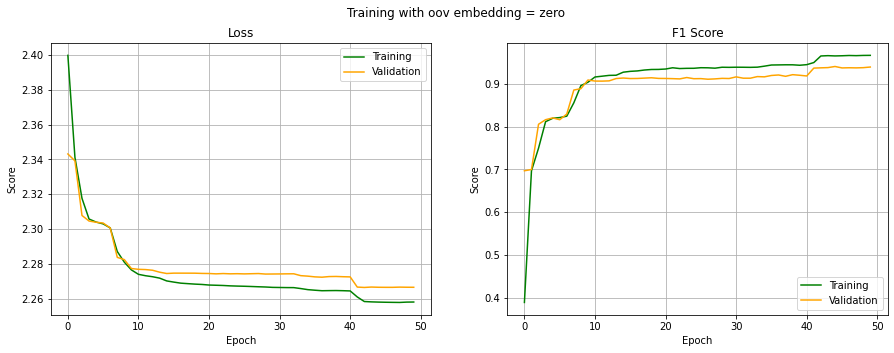

In [22]:
now = datetime.now(pytz.timezone("Asia/Ujung_Pandang"))
path_name = now.strftime("%m-%d-%Y_%H-%M-%S")
root_path = f"../../logs/zero/fold_{hyperparams.fold}/{path_name}"
os.makedirs(root_path)

def looping_step(train_dataloader, val_dataloader, model, optimizer, criterion, train_metric, val_metric, n_epoch=hyperparams.n_epoch, patience=hyperparams.patience, monitor="loss"):    
    start_time = time()
    
    epoch_training_losses = []
    epoch_training_metric_scores = []
    epoch_val_losses = []
    epoch_val_metric_scores = []
    patience_counter = 0
    
    # Hyperparameters
    with open(f"{root_path}/training_history.txt", "a") as f:
        f.write(f"HYPERPARAMETERS\n")
        f.write(f"{'-' * 80}\n")
        for name, value in vars(hyperparams).items():
            f.write(f"{name}: {value}\n")
        
        f.write("\n\nTRAINING PROGRESS\n")
        f.write(f"{'-' * 80}\n")
    
    # Training Progress
    for epoch in range(1, n_epoch + 1):
        print(f"EPOCH-{epoch}")
        with open(f"{root_path}/training_history.txt", "a") as f:
            f.write(f"EPOCH-{epoch}\n")
            f.write(f"Training Step\n")
            
        # Training Step
        print("Training Step")
        batch_training_losses, batch_training_metric_scores = training_step(train_dataloader, model, optimizer, criterion, train_metric, scheduler=None)
        epoch_training_loss = torch.mean(torch.FloatTensor(batch_training_losses))

        epoch_training_loss = torch.mean(torch.FloatTensor(batch_training_losses))
        epoch_training_losses.append(epoch_training_loss.item())

        epoch_training_metric_score = torch.mean(torch.FloatTensor(batch_training_metric_scores))
        epoch_training_metric_scores.append(epoch_training_metric_score.item())
        
        # Validation Step
        with open(f"{root_path}/training_history.txt", "a") as f:
            f.write(f"\nValidation Step\n")
            
        print("\nValidation Step")
        batch_val_losses, batch_val_metric_scores = validation_step(val_dataloader, model, criterion, val_metric)
        epoch_val_loss = torch.mean(torch.FloatTensor(batch_val_losses))

        epoch_val_loss = torch.mean(torch.FloatTensor(batch_val_losses))
        epoch_val_losses.append(epoch_val_loss.item())

        epoch_val_metric_score = torch.mean(torch.FloatTensor(batch_val_metric_scores))
        epoch_val_metric_scores.append(epoch_val_metric_score.item())
        
        with open(f"{root_path}/training_history.txt", "a") as f:
            if monitor == "loss":
                if epoch == 1:
                    best_state_dict = model.state_dict()
                    best_training_loss = epoch_training_loss
                    best_training_metric = epoch_training_metric_score
                    best_val_loss = epoch_val_loss
                    best_val_metric = epoch_val_metric_score
                    
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                elif epoch_training_losses[-1] < epoch_training_losses[-2]:
                    best_state_dict = model.state_dict()
                    best_training_loss = epoch_training_loss
                    best_training_metric = epoch_training_metric_score
                    best_val_loss = epoch_val_loss
                    best_val_metric = epoch_val_metric_score
                    
                    print("\nYeah 🎉😄! Model improved.")
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    
                    f.write("\nYeah 🎉😄! Model improved.\n")
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                else:
                    patience_counter += 1
                    
                    print("\nHuft 😥! Model not improved.")
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    print(f"Patience = {patience_counter}/{patience}❗")
                    
                    f.write("\nHuft 😥! Model not improved.\n")
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                    f.write(f"Patience = {patience_counter}/{patience}❗\n")
            else:
                if epoch == 1:
                    best_state_dict = model.state_dict()
                    best_training_loss = epoch_training_loss
                    best_training_metric = epoch_training_metric_score
                    best_val_loss = epoch_val_loss
                    best_val_metric = epoch_val_metric_score
                    
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                elif epoch_training_metric_scores[-1] > epoch_training_metric_scores[-2]:
                    best_state_dict = model.state_dict()
                    best_training_loss = epoch_training_loss
                    best_training_metric = epoch_training_metric_score
                    best_val_loss = epoch_val_loss
                    best_val_metric = epoch_val_metric_score
                    
                    print("\nYeah 🎉😄! Model improved.")
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    
                    f.write("\nYeah 🎉😄! Model improved.\n")
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                else:
                    patience_counter += 1
                    
                    print("\nHuft 😥! Model not improved.")
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    print(f"Patience = {patience_counter}/{patience}❗\n")
                    
                    f.write("\nHuft 😥! Model not improved.\n")
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                    f.write(f"Patience = {patience_counter}/{patience}❗\n")
                    
            print("=" * 80, end="\n\n")
            
            f.write(f"{'=' * 80}\n\n")
            
            if patience_counter == patience:
                print(f"Early stopping, patience = {patience_counter}/{patience}❗\n")
                
                f.write(f"Early stopping, patience = {patience_counter}/{patience}❗\n")
                break
        
        train_metric.reset()
        val_metric.reset()
        
    finish_time = time()
    
    # Training plot 
    fig, (ax_loss, ax_metric_score) = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

    fig.suptitle(f"Training with oov embedding = zero")

    ax_loss.set_title("Loss")
    ax_loss.set_xlabel("Epoch")
    ax_loss.set_ylabel("Score")
    ax_loss.plot(epoch_training_losses, "green", label="Training")
    ax_loss.plot(epoch_val_losses, "orange", label="Validation")
    ax_loss.legend()
    ax_loss.grid()

    ax_metric_score.set_title("F1 Score")
    ax_metric_score.set_xlabel("Epoch")
    ax_metric_score.set_ylabel("Score")
    ax_metric_score.plot(epoch_training_metric_scores, "green", label="Training")
    ax_metric_score.plot(epoch_val_metric_scores, "orange", label="Validation")
    ax_metric_score.legend()
    ax_metric_score.grid()

    plt.savefig(f"{root_path}/training_plot.jpg", dpi=200)                        
    
    print("TRAINING SUMMARY")
    name_best_training_loss = f"Best {str(criterion).split('(')[0]} training".ljust(34)
    name_best_training_metric = f"Best {str(train_metric).split('(')[0]} validation".ljust(34)
    name_best_validation_loss = f"Best {str(criterion).split('(')[0]} training".ljust(34)
    name_best_validation_metric = f"Best {str(val_metric).split('(')[0]} validation".ljust(34)
    name_training_time = f"Training duration".ljust(34)
    name_training_date = f"Training date".ljust(34)
    
    print(f"{name_best_training_loss}: {best_training_loss:.4f}")
    print(f"{name_best_validation_loss}: {best_val_loss:.4f}")
    print(f"{name_best_training_metric}: {best_training_metric:.4f}")
    print(f"{name_best_validation_metric}: {best_val_metric:.4f}")
    print(f"{name_training_time}: {((finish_time - start_time) / 60):.4f} minutes.")
    print(f"{name_training_date}: {now}")
    
    with open(f"{root_path}/training_history.txt", "a") as f:
        f.write("\nTRAINING SUMMARY\n")
        f.write(f"{'-' * 80}\n")
        f.write(f"{name_best_training_loss}: {best_training_loss:.4f}\n")
        f.write(f"{name_best_validation_loss}: {best_val_loss:.4f}\n")
        f.write(f"{name_best_training_metric}: {best_training_metric:.4f}\n")
        f.write(f"{name_best_validation_metric}: {best_val_metric:.4f}\n")
        f.write(f"{name_training_time}: {((finish_time - start_time) / 60):.4f} minutes.\n")
        f.write(f"{name_training_date}: {now}\n")
    
    # Save epoch losses, epoch metric scores, model, state dict, and oov embedding dict
    pd.DataFrame({
        "epoch": list(range(1, hyperparams.n_epoch + 1)),
        "loss": epoch_training_losses
    }).to_csv(f"{root_path}/training_losses.csv", index=False)
    
    pd.DataFrame({
        "epoch": list(range(1, hyperparams.n_epoch + 1)),
        "f1_score": epoch_training_metric_scores
    }).to_csv(f"{root_path}/training_metric_scores.csv", index=False)
    
    pd.DataFrame({
        "epoch": list(range(1, hyperparams.n_epoch + 1)),
        "loss": epoch_val_losses
    }).to_csv(f"{root_path}/val_losses.csv", index=False)
    
    pd.DataFrame({
        "epoch": list(range(1, hyperparams.n_epoch + 1)),
        "f1_score": epoch_val_metric_scores
    }).to_csv(f"{root_path}/val_metric_scores.csv", index=False)    
    
    filename_model_params = f"{root_path}/model_params.pth"
    torch.save(best_state_dict, filename_model_params)
    
    return epoch_training_losses, epoch_training_metric_scores, epoch_val_losses, epoch_val_metric_scores

epoch_training_losses, epoch_training_metric_scores, epoch_val_losses, epoch_val_metric_scores = looping_step(train_dataloader, val_dataloader, model, optimizer, criterion, train_metric, val_metric)

## End Training

# Evaluation

In [23]:
def evaluation(dataloader, model, criterion, metric):
    model.eval()
    
    with torch.inference_mode():
        for batch, (feature, actual_label) in enumerate(tqdm(dataloader), 1):
            # Forward Propagation
            feature = rearrange(feature, "n s -> s n")
            actual_label = rearrange(actual_label, "n s -> s n")
            embedding = word_embeddings(feature)

            prob = model(
                embedding.to(hyperparams.device),
                actual_label.to(hyperparams.device)
            )

            prob = prob.reshape(-1, prob.shape[-1])
            actual_label = actual_label.reshape(-1)
            pred = rearrange(prob.argmax(dim=1).reshape(feature.shape[0], len(dataloader.dataset)), "s n -> n s")

            loss = criterion(prob, actual_label.to(hyperparams.device))
            metric_score = metric(prob.argmax(dim=1), actual_label.to(hyperparams.device))
            metric_score = metric.compute()

    return loss, metric_score, pred

train_dataloader = DataLoader(train_dataset, batch_size=len(train_dataset))
val_dataloader = DataLoader(val_dataset, batch_size=len(val_dataset))
test_dataloader = DataLoader(test_dataset, batch_size=len(test_dataset))

criterion = nn.CrossEntropyLoss().to(hyperparams.device)
metric = MulticlassF1Score(average="micro", num_classes=24, mdmc_average="samplewise", multiclass=True, ignore_index=label_to_idx["<PAD>"]).to(hyperparams.device)
train_loss, train_f1_score, train_pred_label = evaluation(train_dataloader, model, criterion, metric)

criterion = nn.CrossEntropyLoss().to(hyperparams.device)
metric = MulticlassF1Score(average="micro", num_classes=24, mdmc_average="samplewise", multiclass=True, ignore_index=label_to_idx["<PAD>"]).to(hyperparams.device)
val_loss, val_f1_score, val_pred_label = evaluation(val_dataloader, model, criterion, metric)

criterion = nn.CrossEntropyLoss().to(hyperparams.device)
metric = MulticlassF1Score(average="micro", num_classes=24, mdmc_average="samplewise", multiclass=True, ignore_index=label_to_idx["<PAD>"]).to(hyperparams.device)
test_loss, test_f1_score, test_pred_label = evaluation(test_dataloader, model, criterion, metric)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

In [24]:
train_f1_score, val_f1_score, test_f1_score

(tensor(0.9664, device='cuda:0'),
 tensor(0.9385, device='cuda:0'),
 tensor(0.9374, device='cuda:0'))

In [25]:
train_f1_score, val_f1_score, test_f1_score

(tensor(0.9664, device='cuda:0'),
 tensor(0.9385, device='cuda:0'),
 tensor(0.9374, device='cuda:0'))

## Heatmap

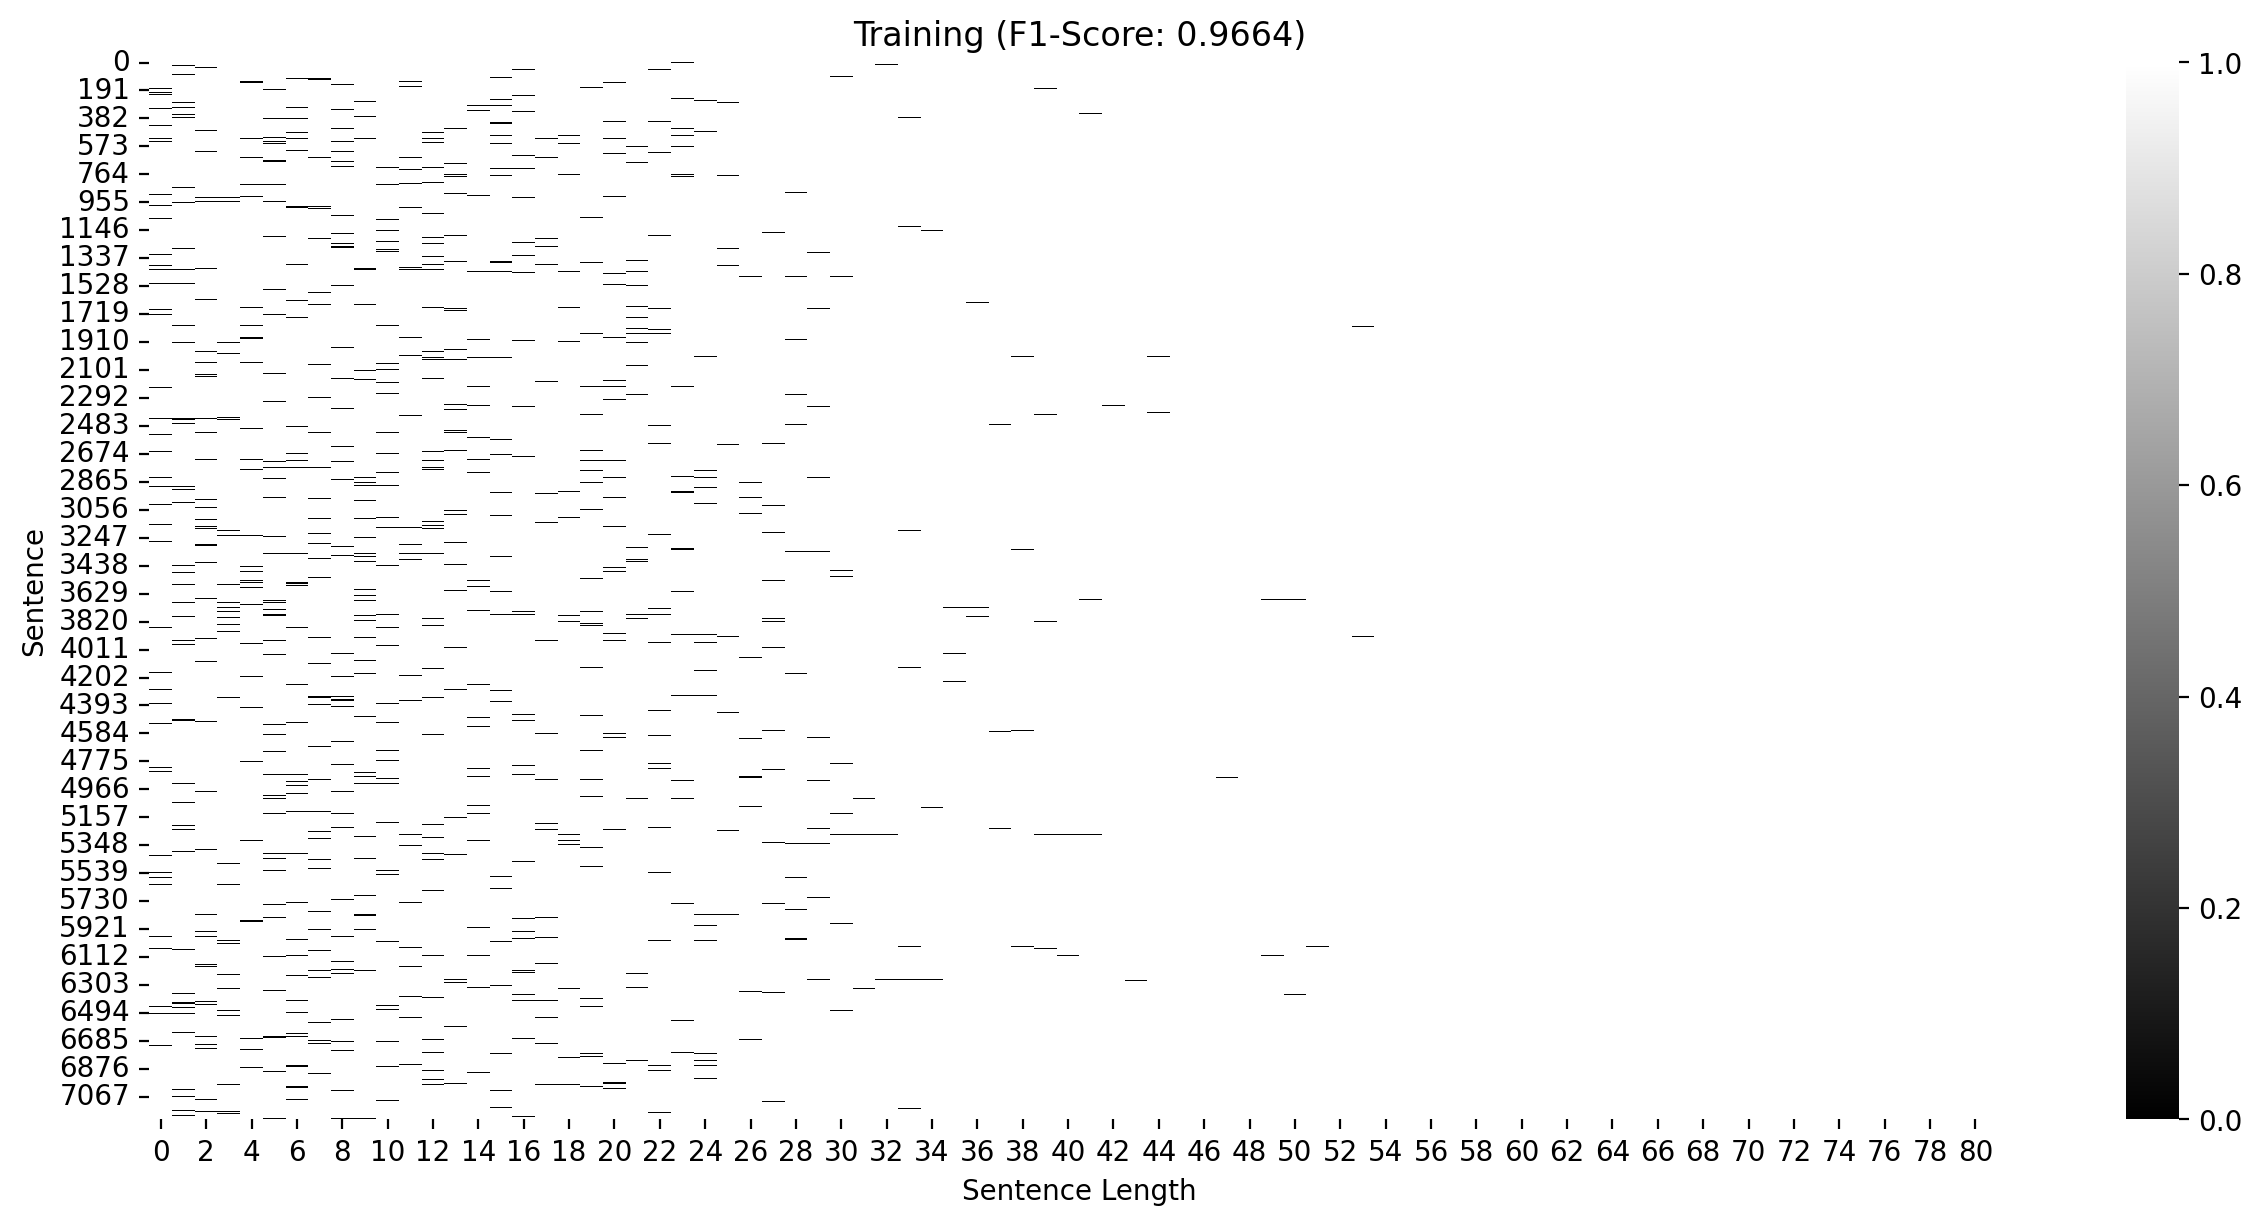

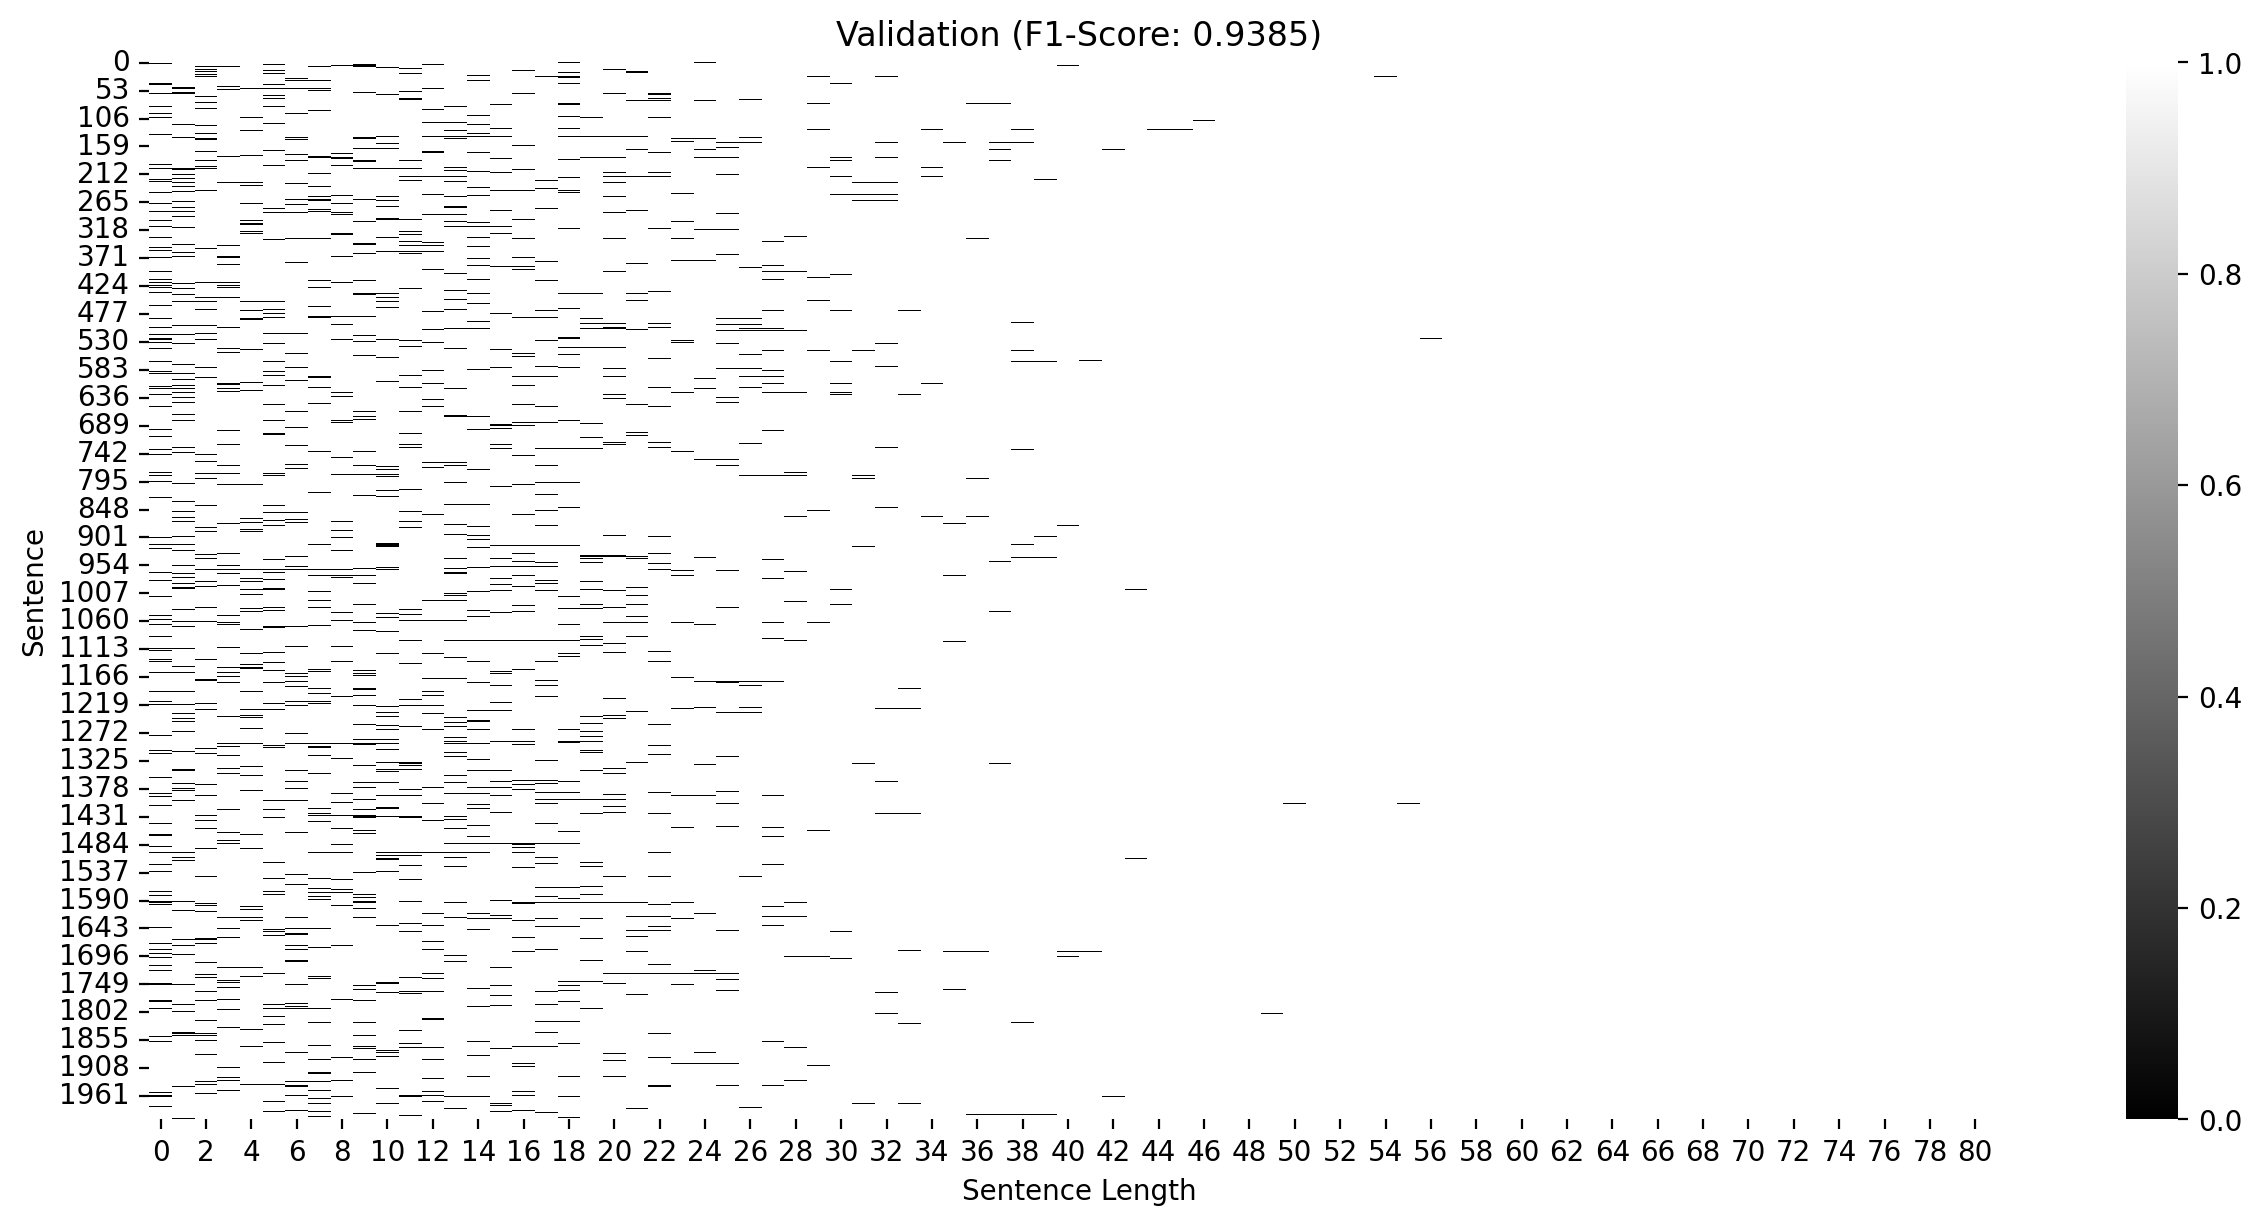

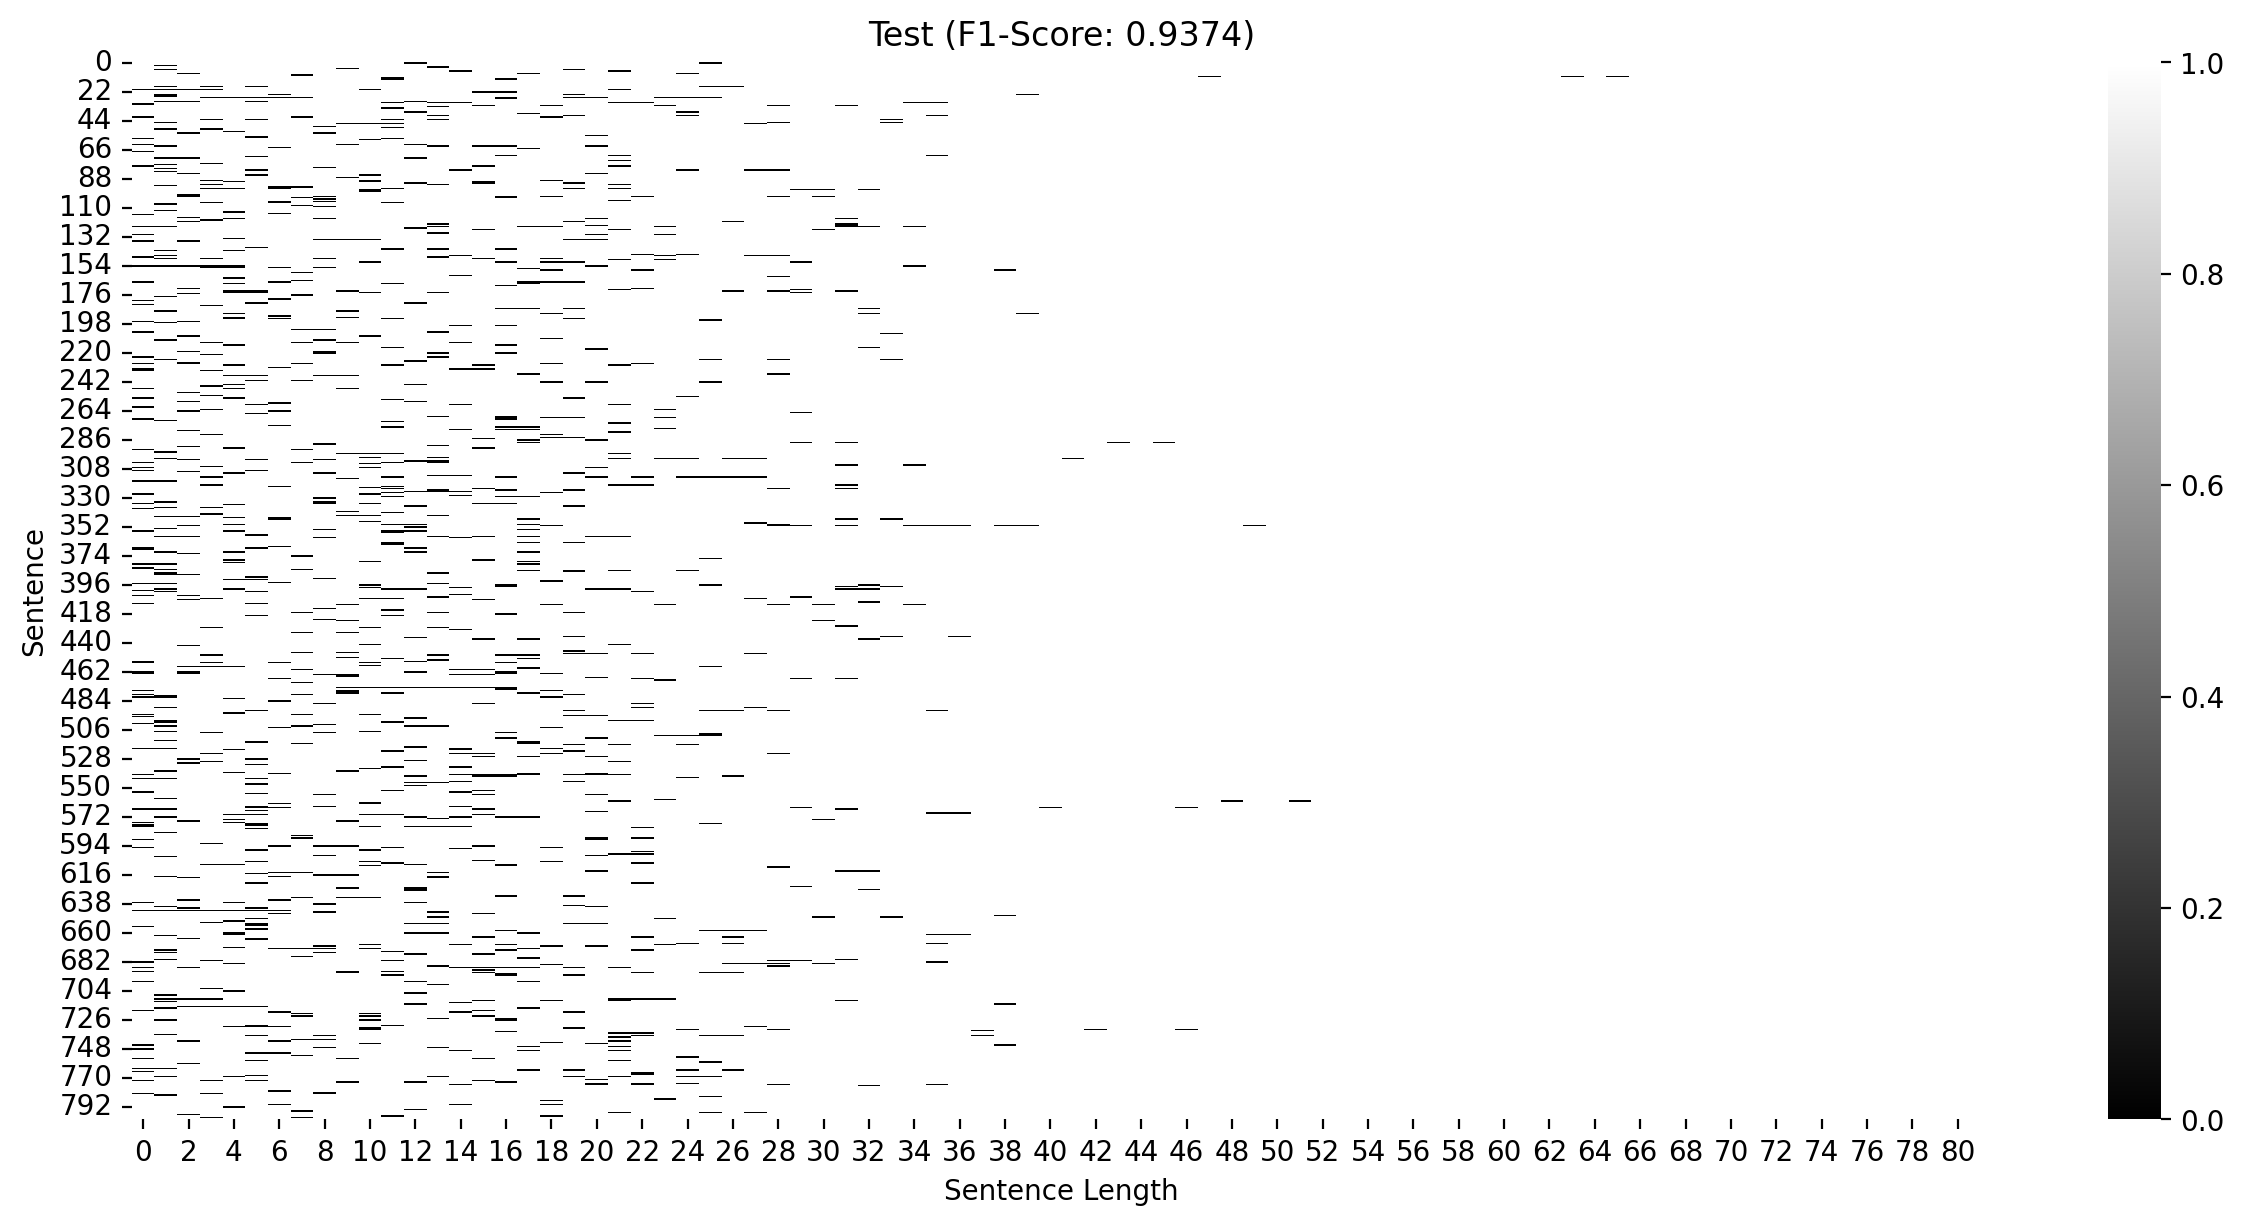

In [26]:
import seaborn as sns

def viz_evaluation(pred_label, actual_label, title):
    plt.figure(figsize=(15, 7), dpi=200)
    sns.heatmap(pred_label.detach().cpu() == actual_label, cbar=True, cmap="binary_r")
    plt.xlabel("Sentence Length")
    plt.ylabel("Sentence")
    plt.title(title)
    plt.savefig(f"{root_path}/heatmap_{title.lower()}.jpg", dpi=200)
    plt.show()

train_actual_label = train_dataloader.dataset.tensors[1]
val_actual_label = val_dataloader.dataset.tensors[1]
test_actual_label = test_dataloader.dataset.tensors[1]

viz_evaluation(train_pred_label, train_actual_label, f"Training (F1-Score: {(train_f1_score):.4f})")
viz_evaluation(val_pred_label, val_actual_label, f"Validation (F1-Score: {(val_f1_score):.4f})")
viz_evaluation(test_pred_label, test_actual_label, f"Test (F1-Score: {(test_f1_score):.4f})")

## Confusion Matrix

/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: 144 NaN values found in confusion matrix have been replaced with zeros.
  warnings.warn(*args, **kwargs)


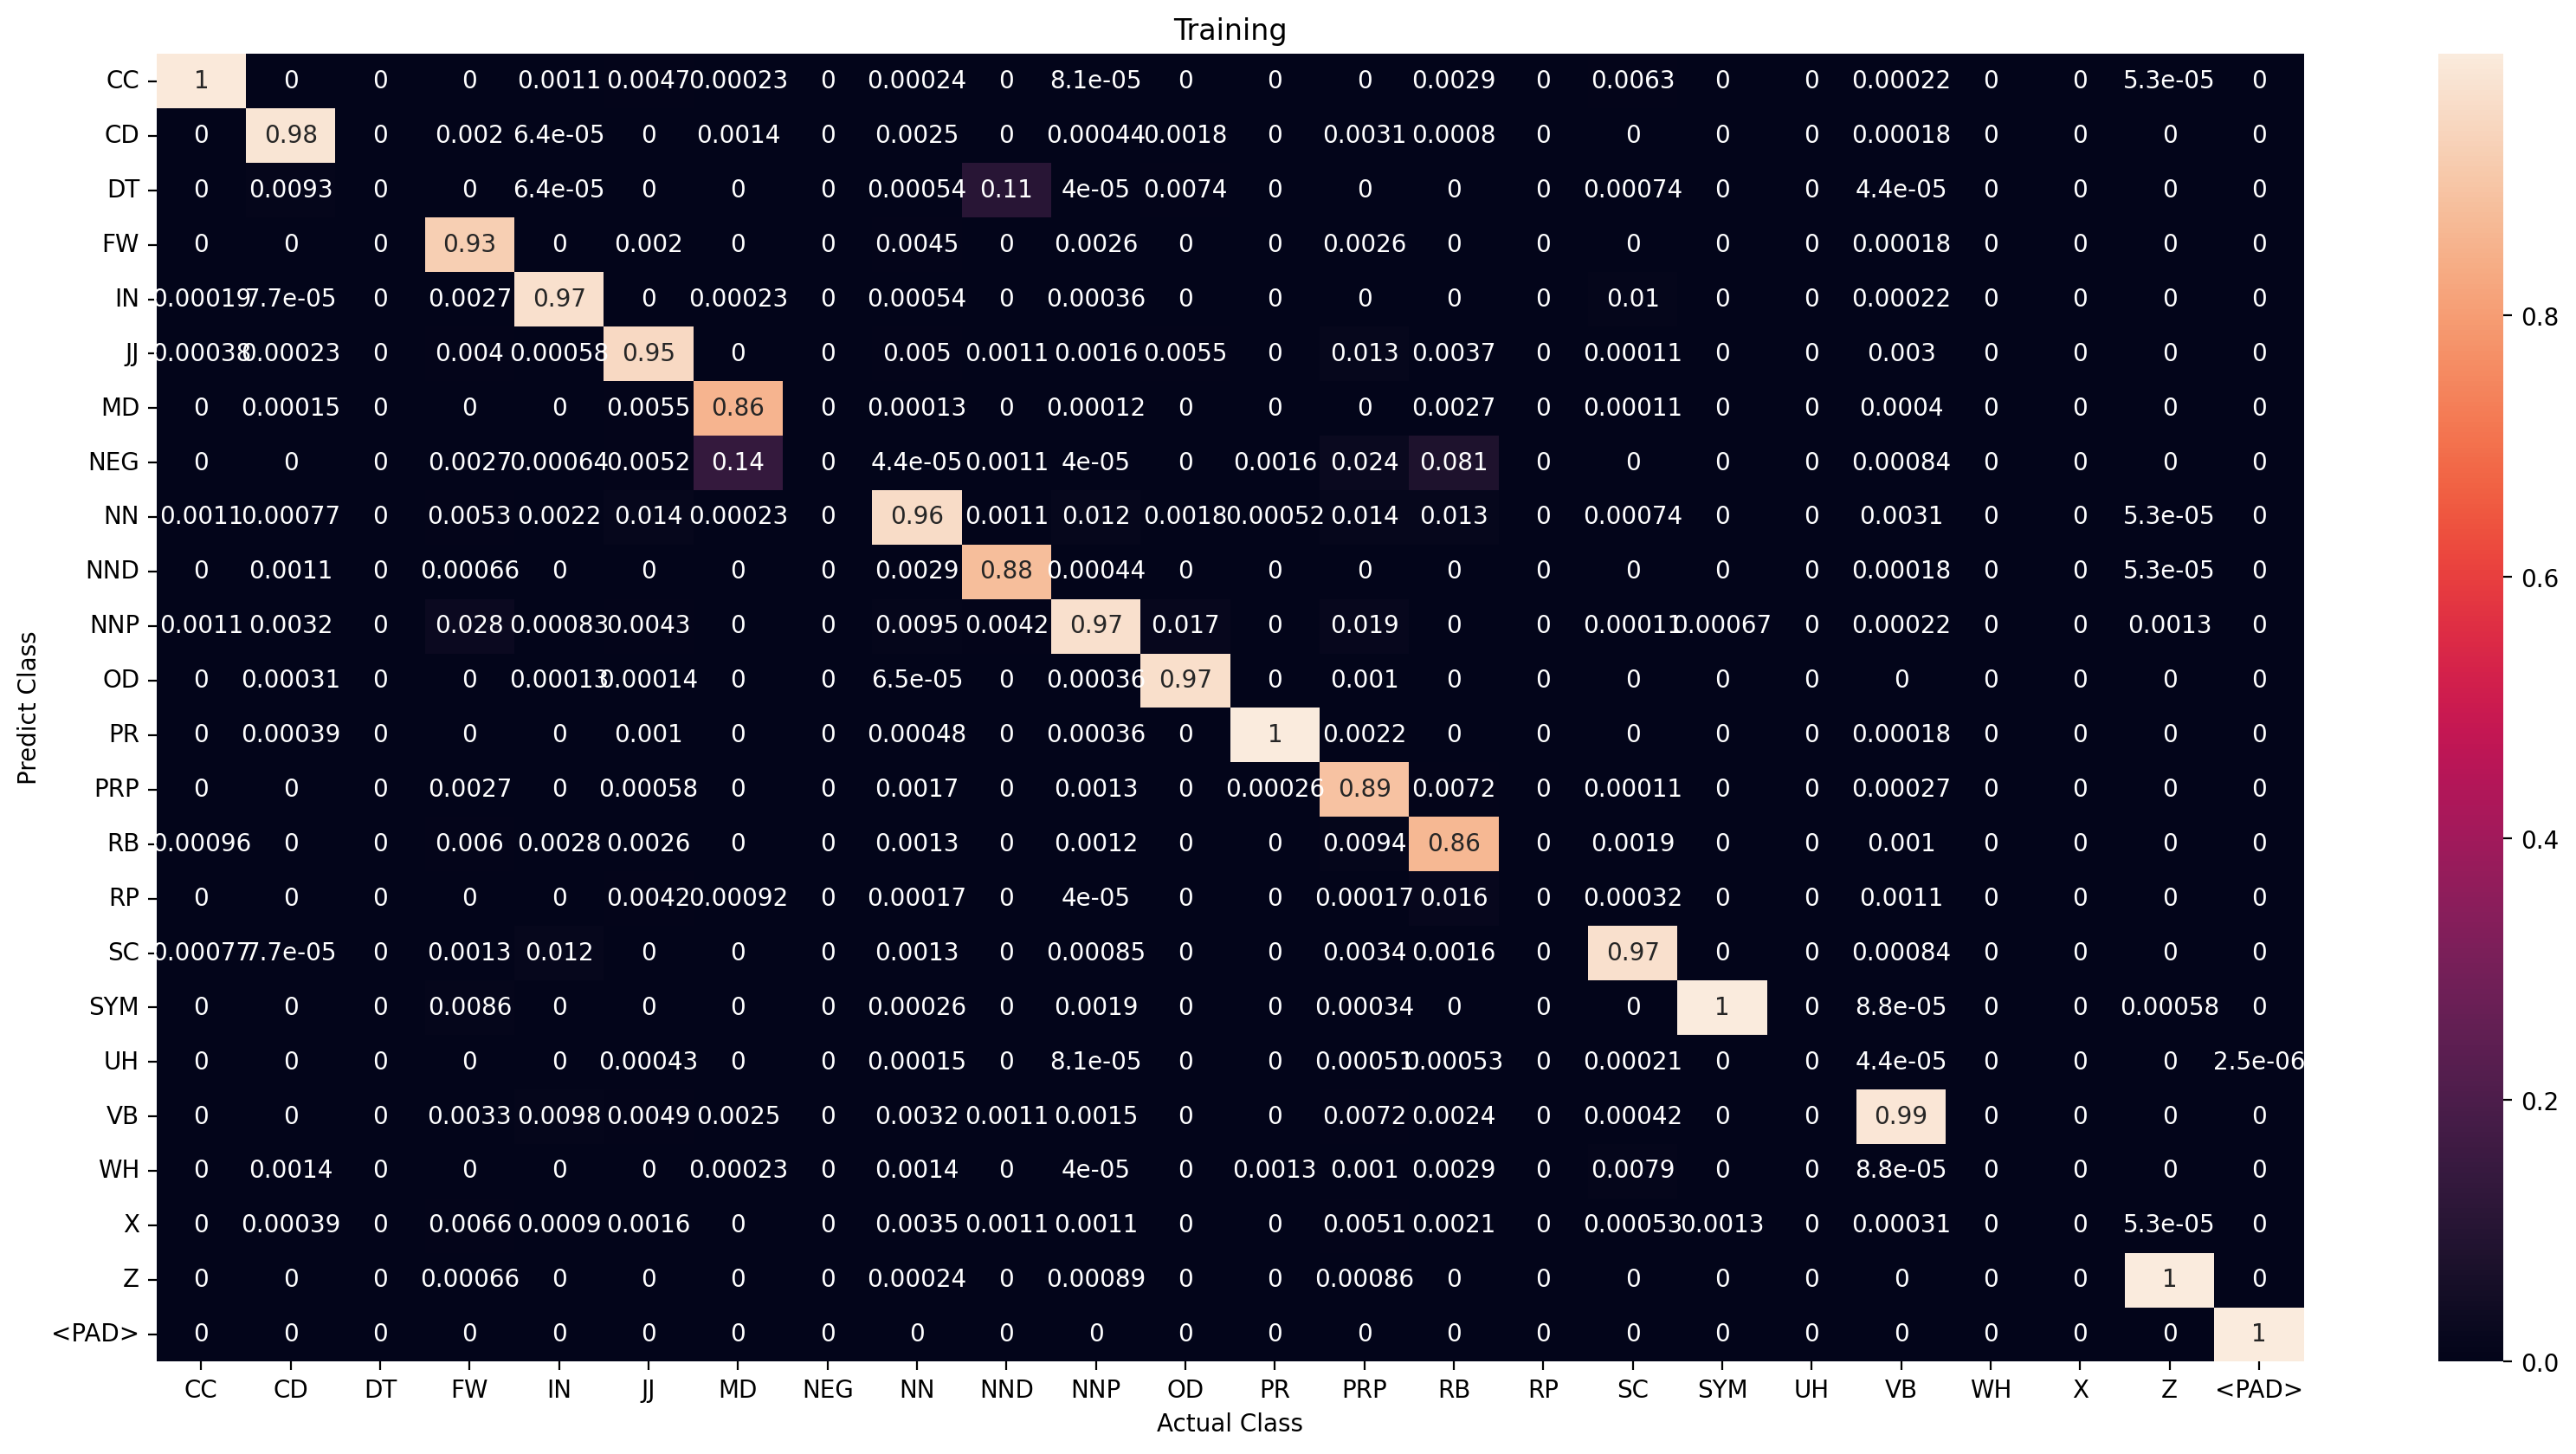

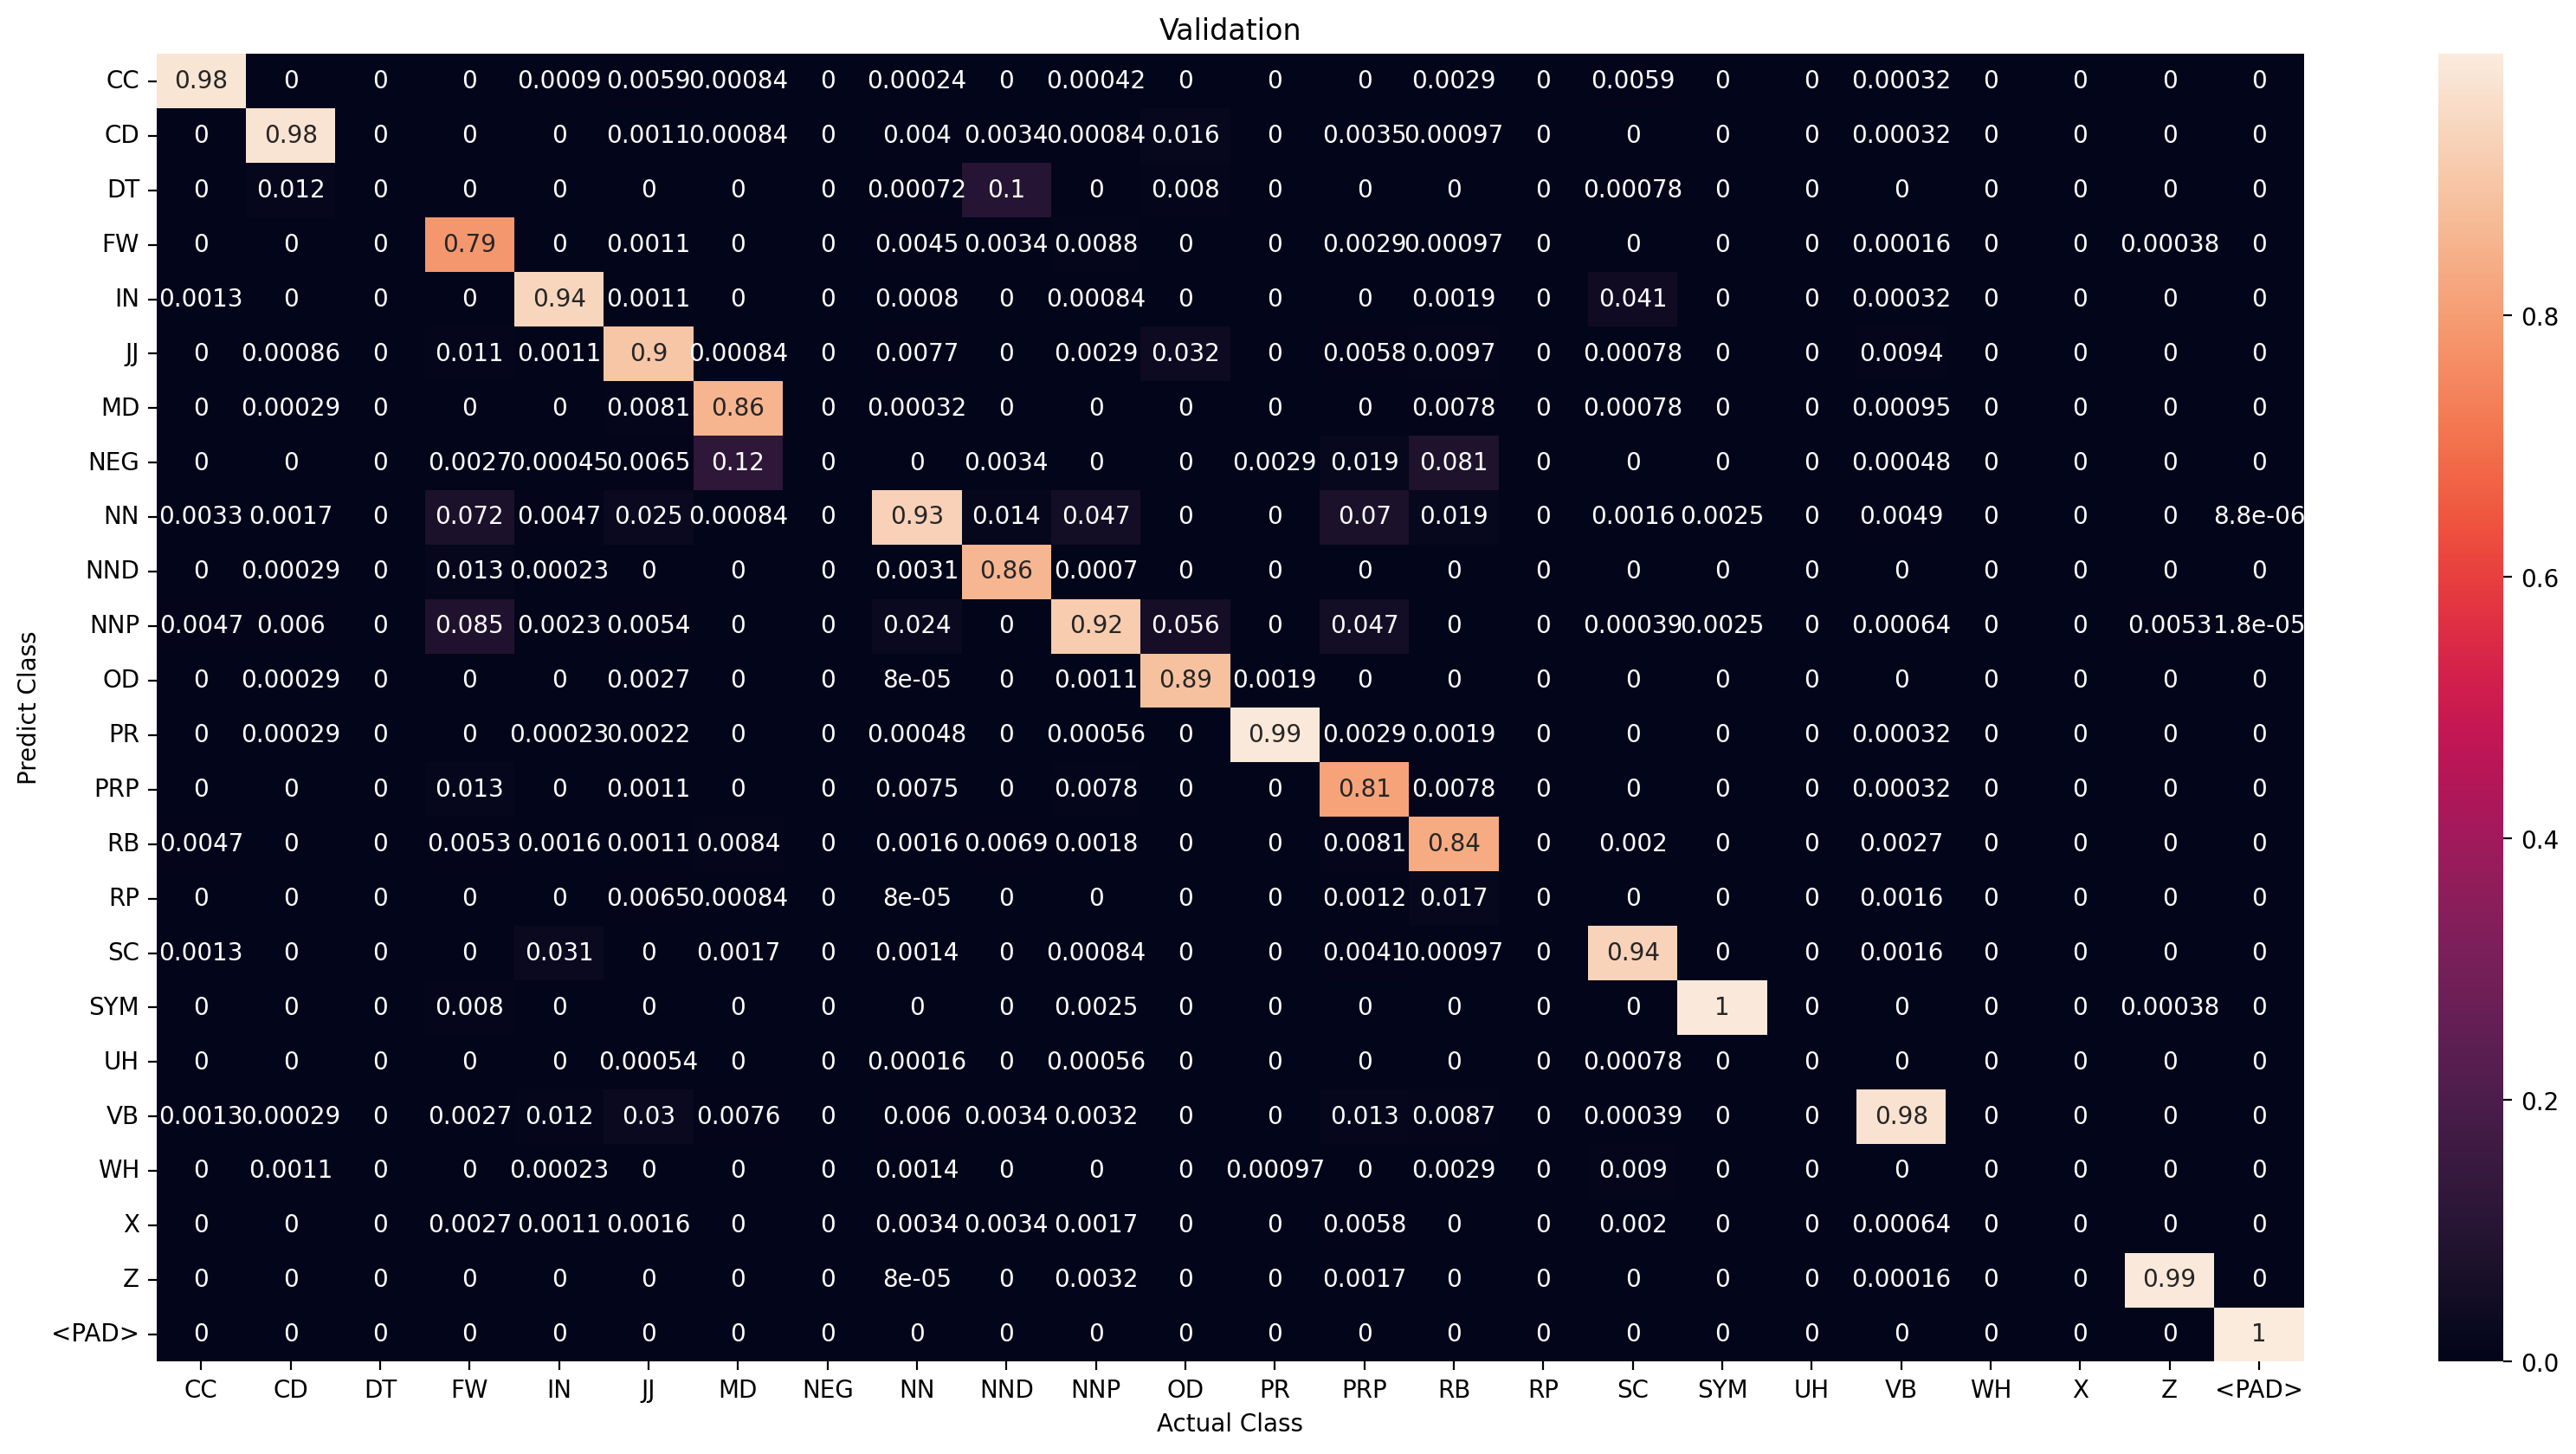

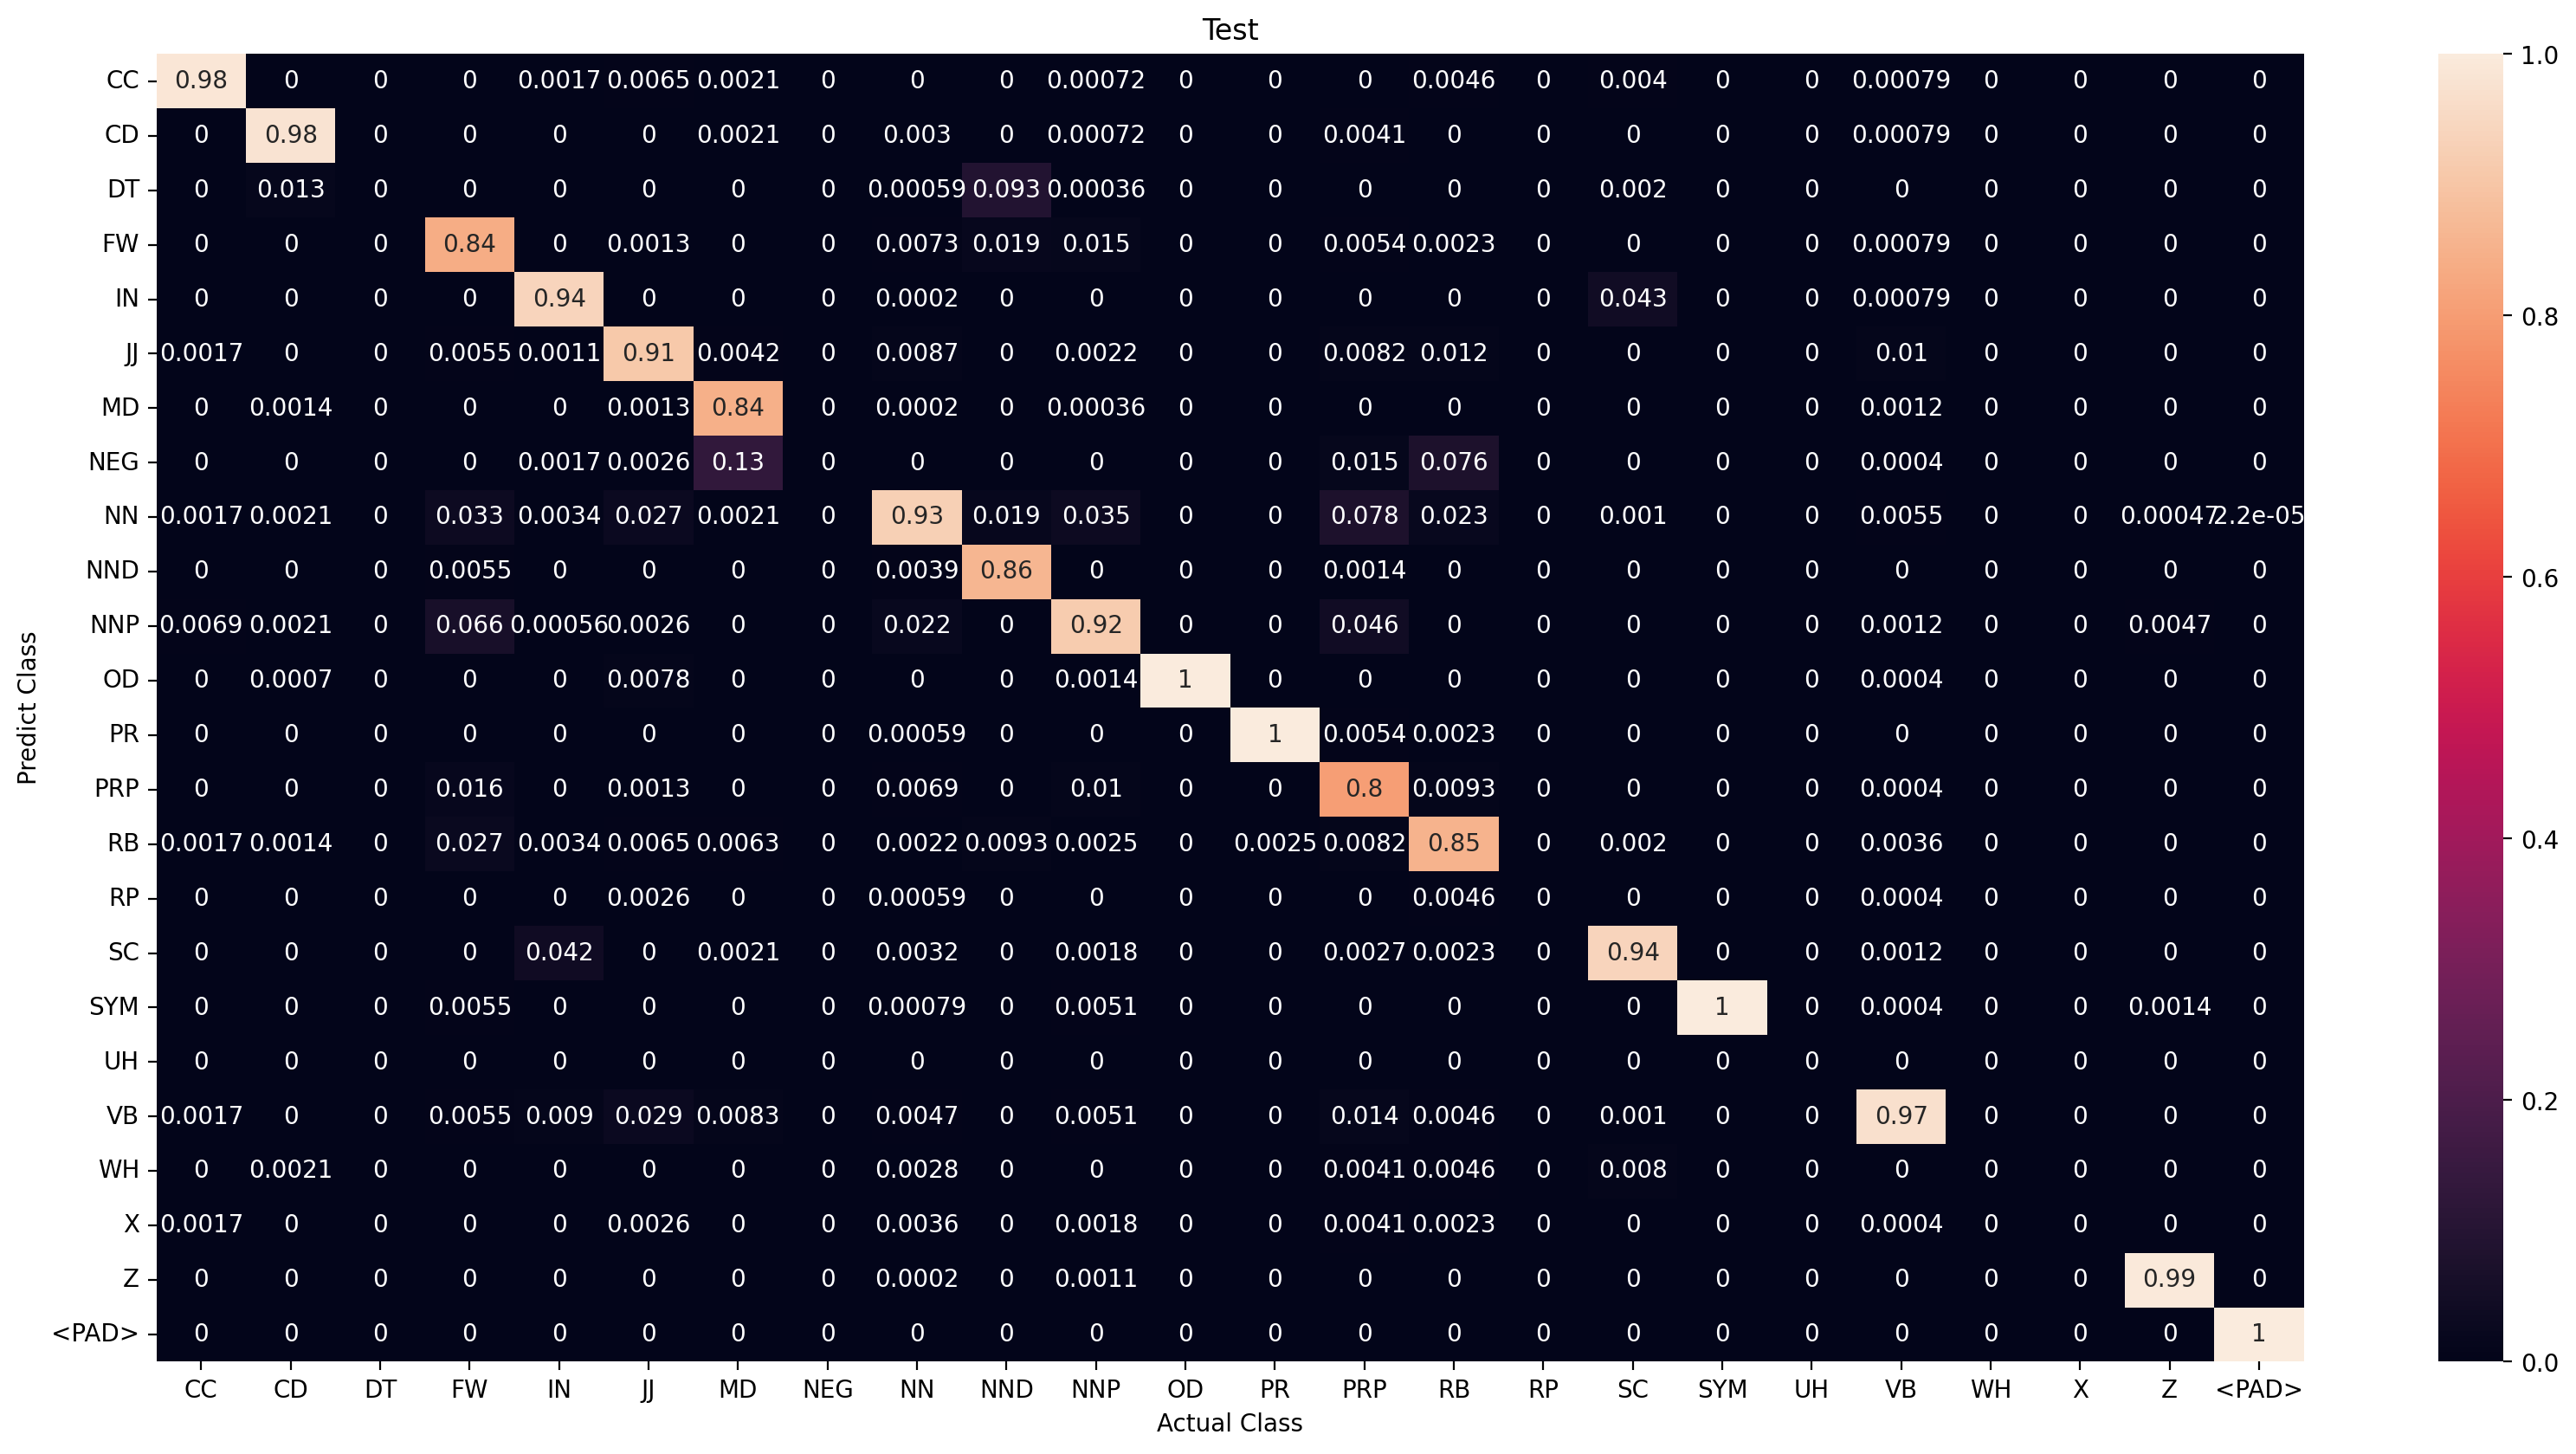

In [27]:
def confusion_matrix(pred_class, actual_class, title, normalize=None):
    conf_mat = MulticlassConfusionMatrix(num_classes=24, normalize=normalize)
    plt.figure(figsize=(20, 10), dpi=200)
    sns.heatmap(conf_mat(pred_class.detach().cpu(), actual_class), annot=True, fmt=".2g", xticklabels=list(label_to_idx.keys()), yticklabels=list(label_to_idx.keys()));
    plt.yticks(rotation=0)
    plt.title(title)
    plt.xlabel("Actual Class")
    plt.ylabel("Predict Class")
    plt.savefig(f"{root_path}/conf_matrix_{title.lower()}.jpg", dpi=200)

confusion_matrix(train_pred_label, train_actual_label, "Training", "pred")
confusion_matrix(val_pred_label,val_actual_label, "Validation", "pred")
confusion_matrix(test_pred_label, test_actual_label, "Test", "pred")

## Prediction Table

In [28]:
def number_wrong_pred_each_class(pred_class, actual_class):
    classes, count_class = actual_class.flatten().unique(return_counts=True)
    conf_mat = MulticlassConfusionMatrix(num_classes=24, normalize="none")
    correct_pred_count_class = conf_mat(pred_class.detach().cpu(), actual_class).diag()
    
    correct_pred = {idx_to_label[label.item()]: count.item() for label, count in zip(classes, (correct_pred_count_class))}
    wrong_pred = {idx_to_label[label.item()]: count.item() for label, count in zip(classes, (count_class - correct_pred_count_class))}
    
    return correct_pred, wrong_pred

correct_pred, wrong_pred = number_wrong_pred_each_class(train_pred_label, train_actual_label)
print(f"| {'Number class'.ljust(14)} | {'Correct prediction'.ljust(12)} | {'Wrong prediction'.ljust(12)} |")
for (label_correct_pred, count_correct_pred), (label_wrong_pred, count_wrong_pred) in zip(correct_pred.items(), wrong_pred.items()):
    print(f"| {str(label_correct_pred).ljust(6)}: {str(count_correct_pred + count_wrong_pred).ljust(7)}| {label_correct_pred.ljust(6)}: {str(count_correct_pred).ljust(10)} | {label_wrong_pred.ljust(6)}: {str(count_wrong_pred).ljust(8)} |")

| Number class   | Correct prediction | Wrong prediction |
| CC    : 5336   | CC    : 5196       | CC    : 140      |
| CD    : 12904  | CD    : 12743      | CD    : 161      |
| DT    : 263    | DT    : 0          | DT    : 263      |
| FW    : 1697   | FW    : 1395       | FW    : 302      |
| IN    : 15290  | IN    : 15148      | IN    : 142      |
| JJ    : 7049   | JJ    : 6602       | JJ    : 447      |
| MD    : 3783   | MD    : 3714       | MD    : 69       |
| NEG   : 1126   | NEG   : 0          | NEG   : 1126     |
| NN    : 44769  | NN    : 44097      | NN    : 672      |
| NND   : 998    | NND   : 836        | NND   : 162      |
| NNP   : 24884  | NNP   : 24157      | NNP   : 727      |
| OD    : 550    | OD    : 525        | OD    : 25       |
| PR    : 3878   | PR    : 3818       | PR    : 60       |
| PRP   : 5355   | PRP   : 5204       | PRP   : 151      |
| RB    : 3517   | RB    : 3254       | RB    : 263      |
| RP    : 131    | RP    : 0          | RP    : 131     

In [29]:
train_actual_label[308], train_pred_label[308]

(tensor([ 8, 19, 22, 10, 22, 19, 10,  6, 19,  4,  1,  8, 16, 19,  8, 19,  0,  8,
          5, 16, 19, 19,  8,  8, 22, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23]),
 tensor([ 8, 19, 22, 10, 22, 19, 10,  6, 19,  4,  1,  8, 16, 19,  8, 19,  0,  8,
          5, 16, 19, 19,  8,  8, 22, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23], device='cuda:0'))

In [30]:
train_actual_label[308].detach().cpu() == train_pred_label[308].detach().cpu()

tensor([True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True])

## OOV prediction is correct 

In [31]:
def oov_flag_token(sentences, max_seq_len=hyperparams.max_seq_len):
    sent_copy = deepcopy(sentences)
    sent = []
    oov_flag = []
    
    for sentence in tqdm(sent_copy):
        for token in sentence:
            sent.append(token[2])
        
        for _ in range(max_seq_len- len(sentence)):
            sent.append(False)
        
        oov_flag.append(sent)
        sent = []
        
    return np.array(oov_flag)

train_oov_flag = oov_flag_token(train_sentences, max_seq_len=hyperparams.max_seq_len)
val_oov_flag = oov_flag_token(val_sentences, max_seq_len=hyperparams.max_seq_len)
test_oov_flag = oov_flag_token(test_sentences, max_seq_len=hyperparams.max_seq_len)

def pencentage_oov_pred_correct(pred_oov_flag, oov_flag_tensor):
    oov_correct_counter = 0
    oov_wrong_counter = 0

    for pred, oov_label in tqdm(zip(pred_oov_flag, oov_flag_tensor)):
        if pred == True and oov_label == True:
            oov_correct_counter += 1
        elif pred == False and oov_label == True:
            oov_wrong_counter += 1
        else:
            continue
            
    return oov_correct_counter, oov_wrong_counter

train_pred_oov_flag = (train_actual_label == train_pred_label.detach().cpu()).flatten()
val_pred_oov_flag = (val_actual_label == val_pred_label.detach().cpu()).flatten()
test_pred_oov_flag = (test_actual_label == test_pred_label.detach().cpu()).flatten()
train_oov_flag_tensor = torch.tensor(train_oov_flag).flatten()
val_oov_flag_tensor = torch.tensor(val_oov_flag).flatten()
test_oov_flag_tensor = torch.tensor(test_oov_flag).flatten()

train_oov_correct_counter, train_oov_wrong_counter = pencentage_oov_pred_correct(train_pred_oov_flag, train_oov_flag_tensor)
val_oov_correct_counter, val_oov_wrong_counter = pencentage_oov_pred_correct(val_pred_oov_flag, val_oov_flag_tensor)
test_oov_correct_counter, test_oov_wrong_counter = pencentage_oov_pred_correct(test_pred_oov_flag, test_oov_flag_tensor)

  0%|          | 0/7222 [00:00<?, ?it/s]

  0%|          | 0/2006 [00:00<?, ?it/s]

  0%|          | 0/802 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [32]:
def print_percentage_pred_oov(title, oov_correct_counter, oov_wrong_counter):
    print(f"{title}")
    print(f"Number OOV token            : {oov_correct_counter + oov_wrong_counter}")
    print(f"Correct prediction          : {oov_correct_counter}")
    print(f"Wrong prediction            : {oov_wrong_counter}")
    print(f"Percentage correct oov pred : {oov_correct_counter / (oov_correct_counter + oov_wrong_counter) * 100}\n")
    
    with open(f"{root_path}/oov_summary.txt", "a") as f:
        f.write(f"{title}\n")
        f.write(f"Number OOV token            : {oov_correct_counter + oov_wrong_counter}\n")
        f.write(f"Correct prediction          : {oov_correct_counter}\n")
        f.write(f"Wrong prediction            : {oov_wrong_counter}\n")
        f.write(f"Percentage correct oov pred : {oov_correct_counter / (oov_correct_counter + oov_wrong_counter) * 100}\n\n")

In [33]:
print_percentage_pred_oov("Training", train_oov_correct_counter, train_oov_wrong_counter)
print_percentage_pred_oov("Validation", val_oov_correct_counter, val_oov_wrong_counter)
print_percentage_pred_oov("Test", test_oov_correct_counter, test_oov_wrong_counter)

Training
Number OOV token            : 11934
Correct prediction          : 10389
Wrong prediction            : 1545
Percentage correct oov pred : 87.05379587732529

Validation
Number OOV token            : 3261
Correct prediction          : 2368
Wrong prediction            : 893
Percentage correct oov pred : 72.61576203618522

Test
Number OOV token            : 1367
Correct prediction          : 964
Wrong prediction            : 403
Percentage correct oov pred : 70.51938551572788



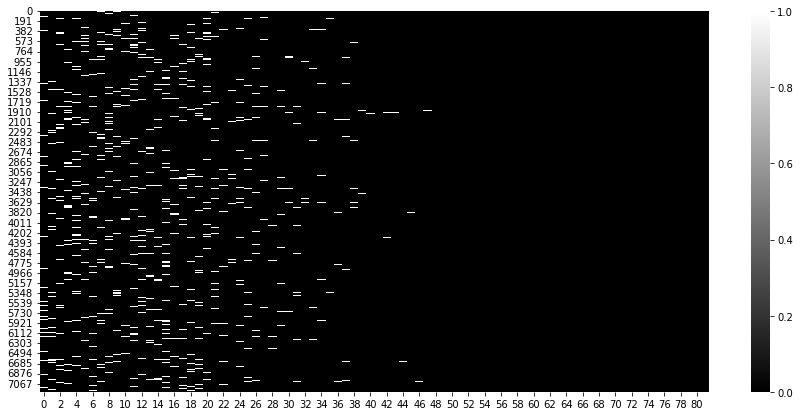

In [34]:
plt.figure(figsize=(15, 7))
sns.heatmap(train_oov_flag, cmap=plt.cm.binary_r);

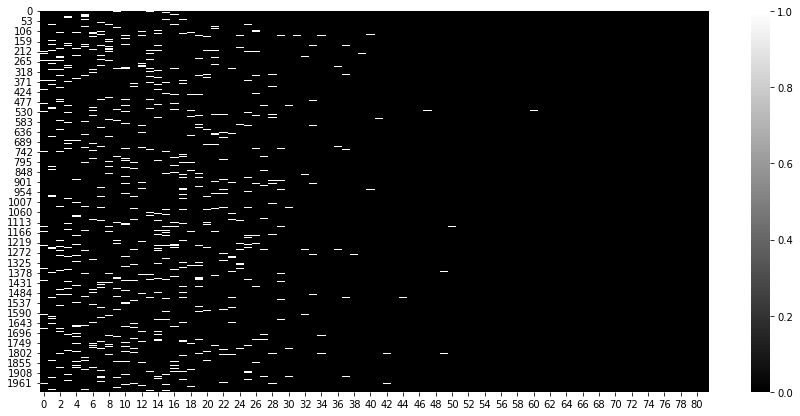

In [35]:
plt.figure(figsize=(15, 7))
sns.heatmap(val_oov_flag, cmap=plt.cm.binary_r);

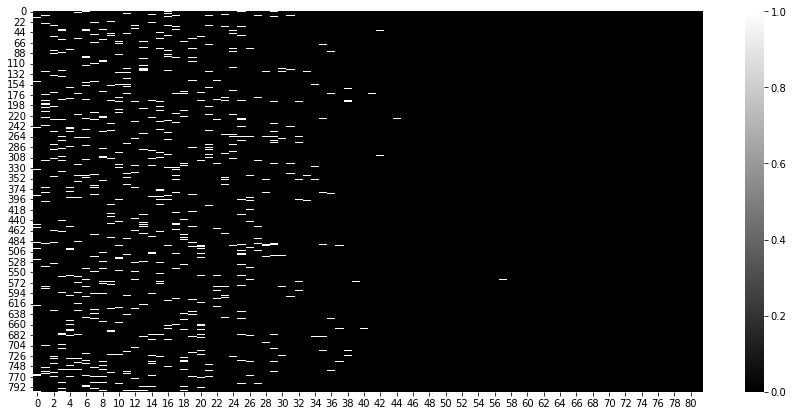

In [36]:
plt.figure(figsize=(15, 7))
sns.heatmap(test_oov_flag, cmap=plt.cm.binary_r);